In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pylab as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
conn = psql.connect(dbname='datawarehouse',
                    host='localhost', user='gabriel', password='gyfu')


In [16]:
citiesData = []
for city in range(1, 30):
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, count(f.*) from date d left join fires f on d.id = f.dateid and f.locationid = {} group by d.day, d.month, d.year order by d.year, d.month, d.day asc;'.format(city))
    fireCount = cur.fetchall()
    cur.close()
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, w.mimtemp, w.maxtemp, w.rainfall from date d left join weather w on d.id = w.dateid and w.locationid = {} order by d.year, d.month, d.day asc;'.format(city))
    weatherData = cur.fetchall()
    cur.close()

    index = []
    count = []
    for day in fireCount:
        index.append(str(day[0]) + '-' + str(day[1]) + '-' + str(day[2]))
        count.append(day[3])

    fireCountDB = pd.DataFrame(
        data={'date': index, 'count': count})

    index = []
    mimtemp = []
    maxtemp = []
    rainfall = []
    for day in weatherData:
        index.append(str(day[0]) + '-' + str(day[1]) + '-' + str(day[2]))
        mimtemp.append(day[3])
        maxtemp.append(day[4])
        rainfall.append(day[5])

    weatherDataDB = pd.DataFrame(data={'date': index, 'mimtemp': mimtemp, 'maxtemp': maxtemp,
                                 'rainfall': rainfall})
    sup = weatherDataDB.merge(fireCountDB)
    sup = sup.drop(sup[sup['mimtemp'].isnull() & sup['maxtemp'].isnull() & sup['rainfall'].isnull()].index)
    sup['maxtemp'].fillna(0, inplace=True)
    sup['mimtemp'].fillna(0, inplace=True)
    sup['rainfall'].fillna(0, inplace=True)
    citiesData.append((city, sup.set_index('date').copy()))

del citiesData[21]


C:\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


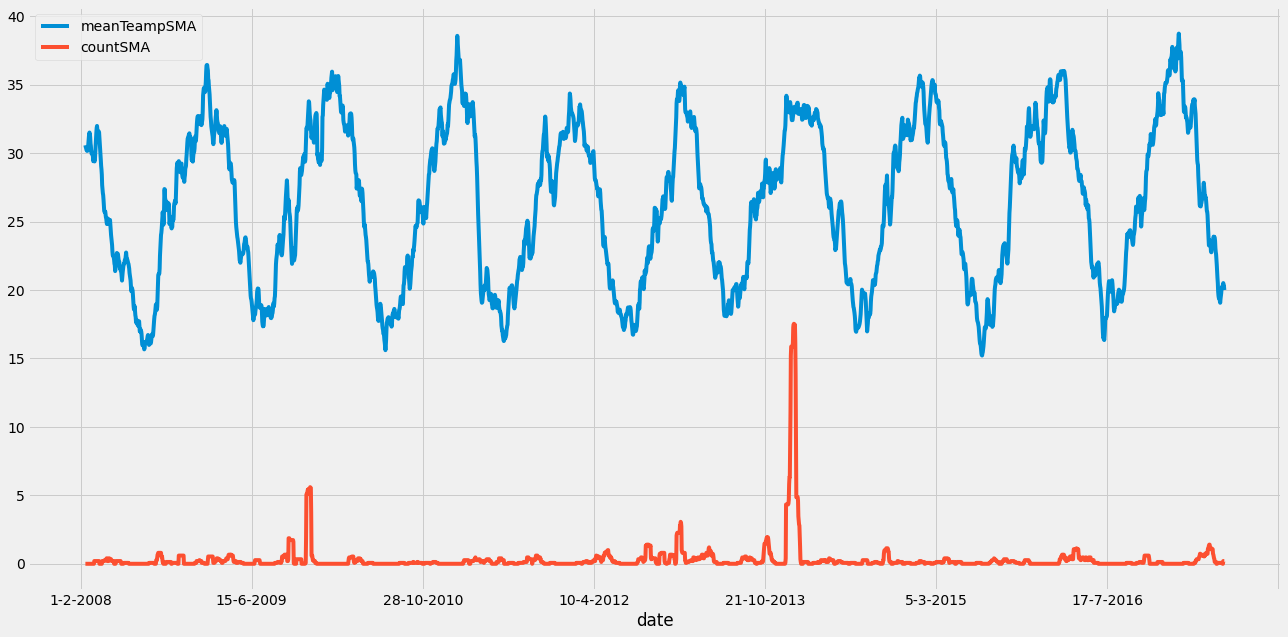

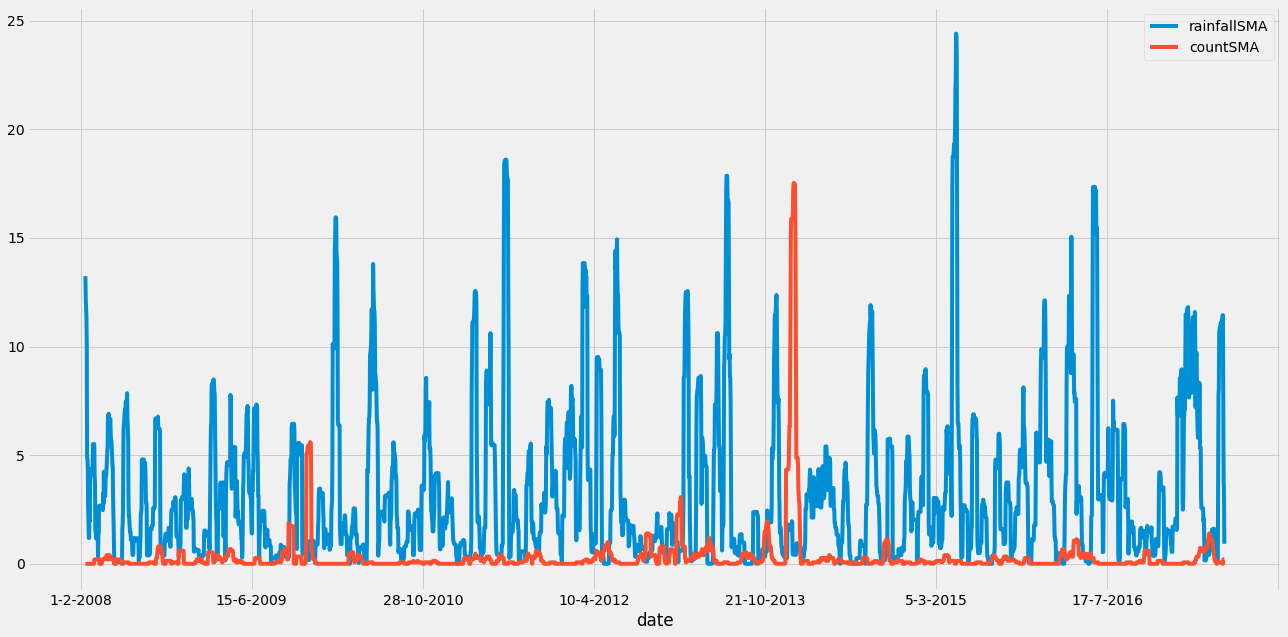

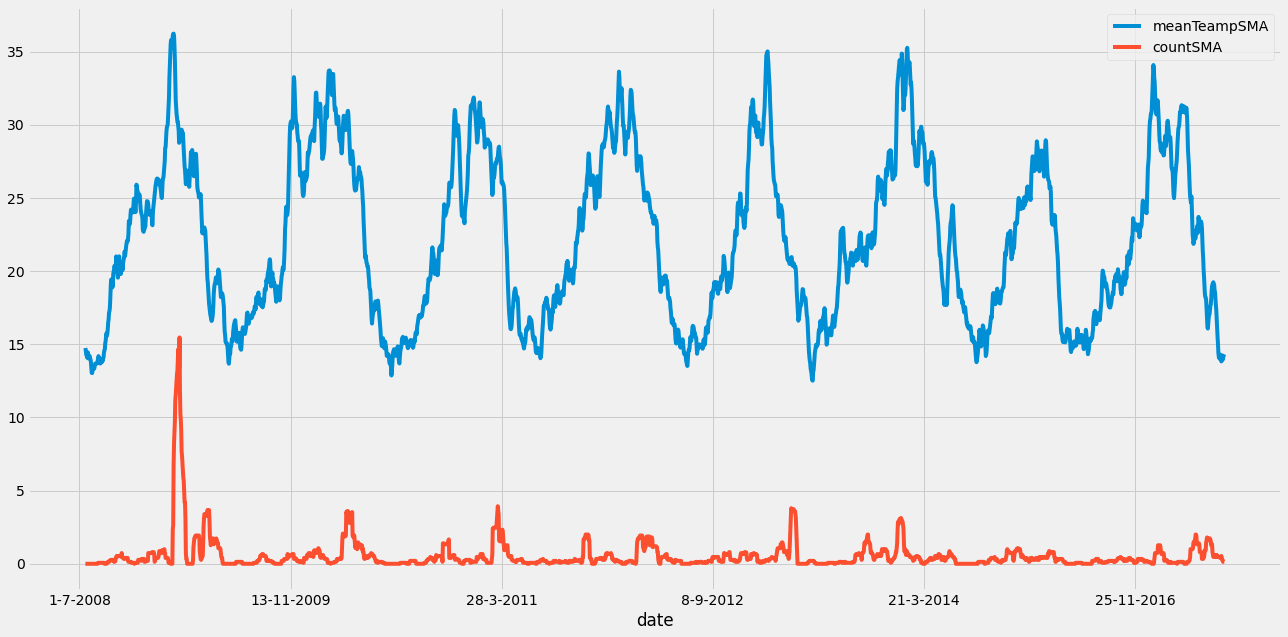

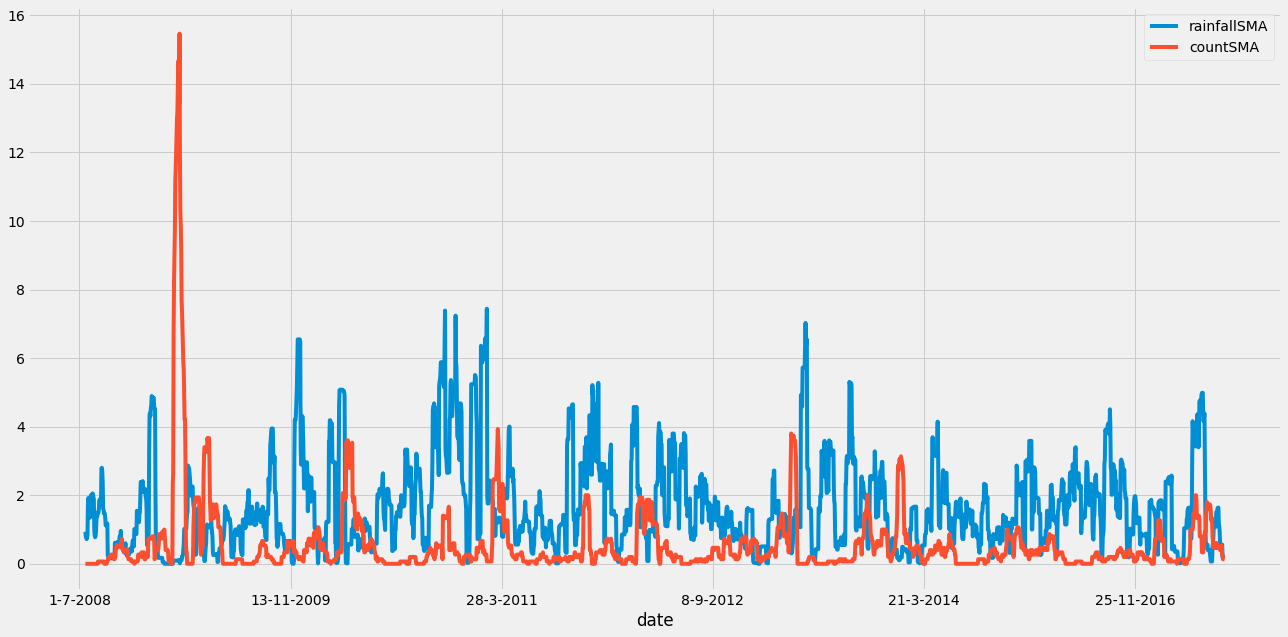

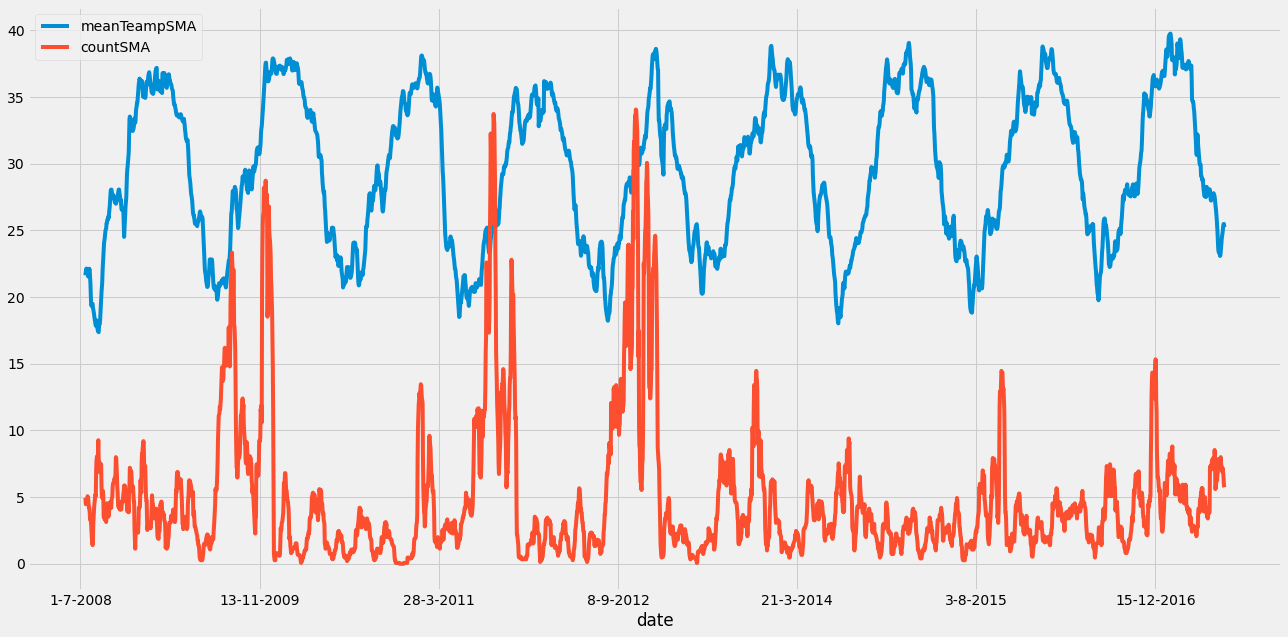

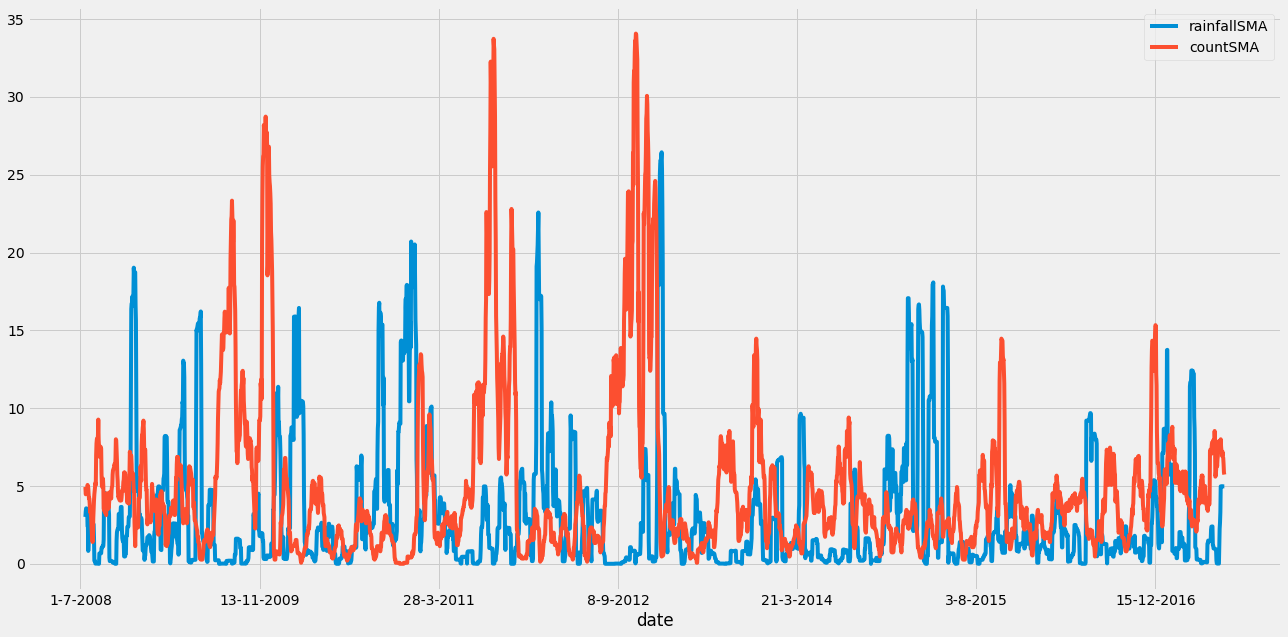

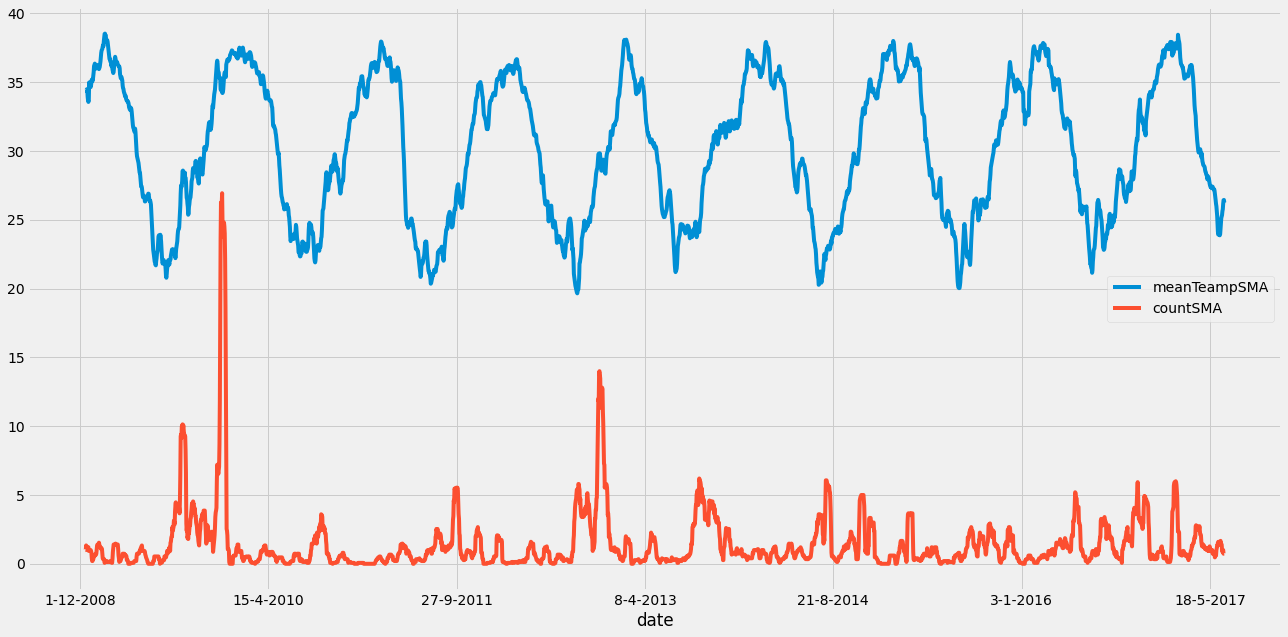

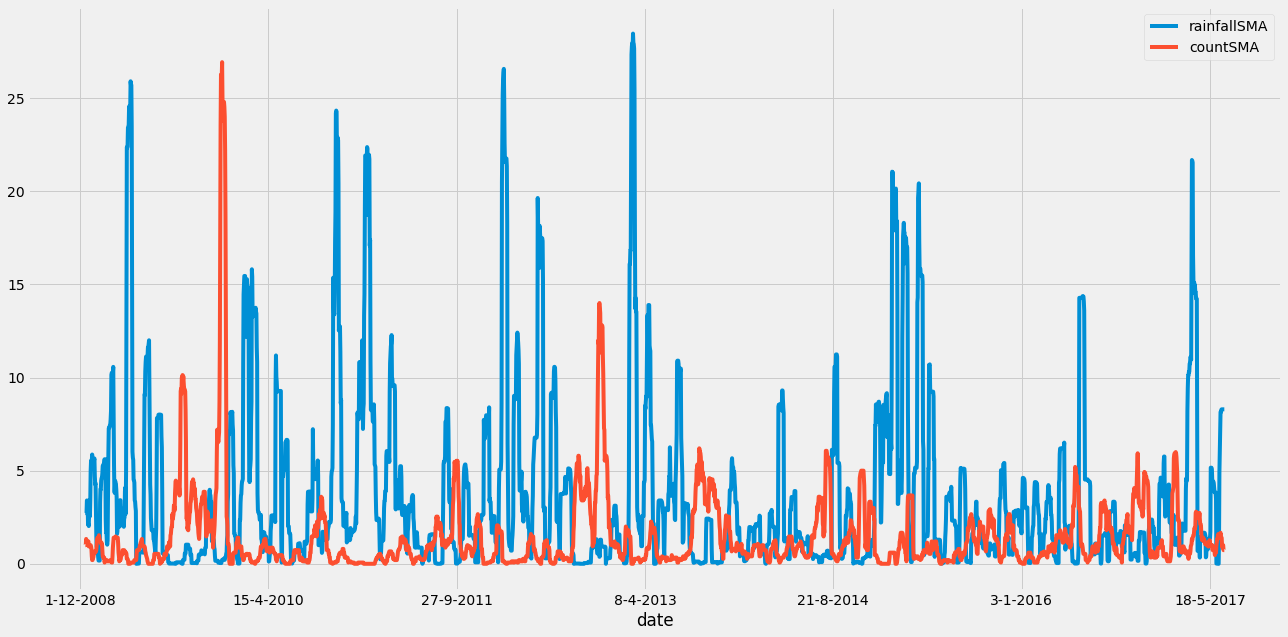

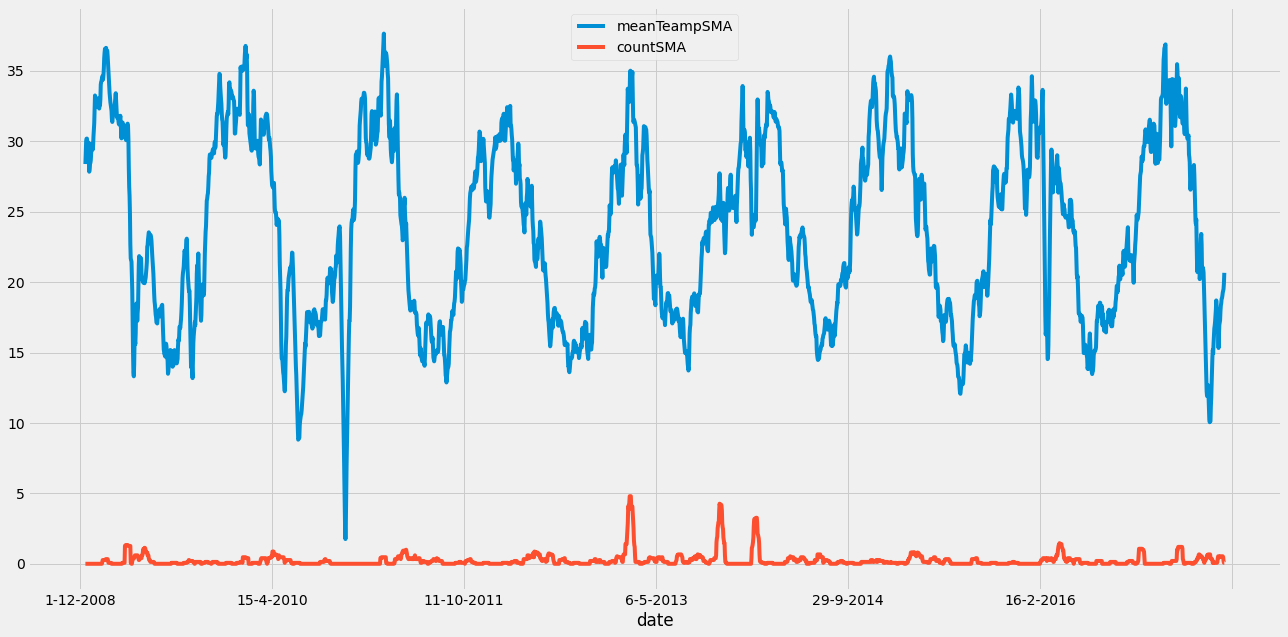

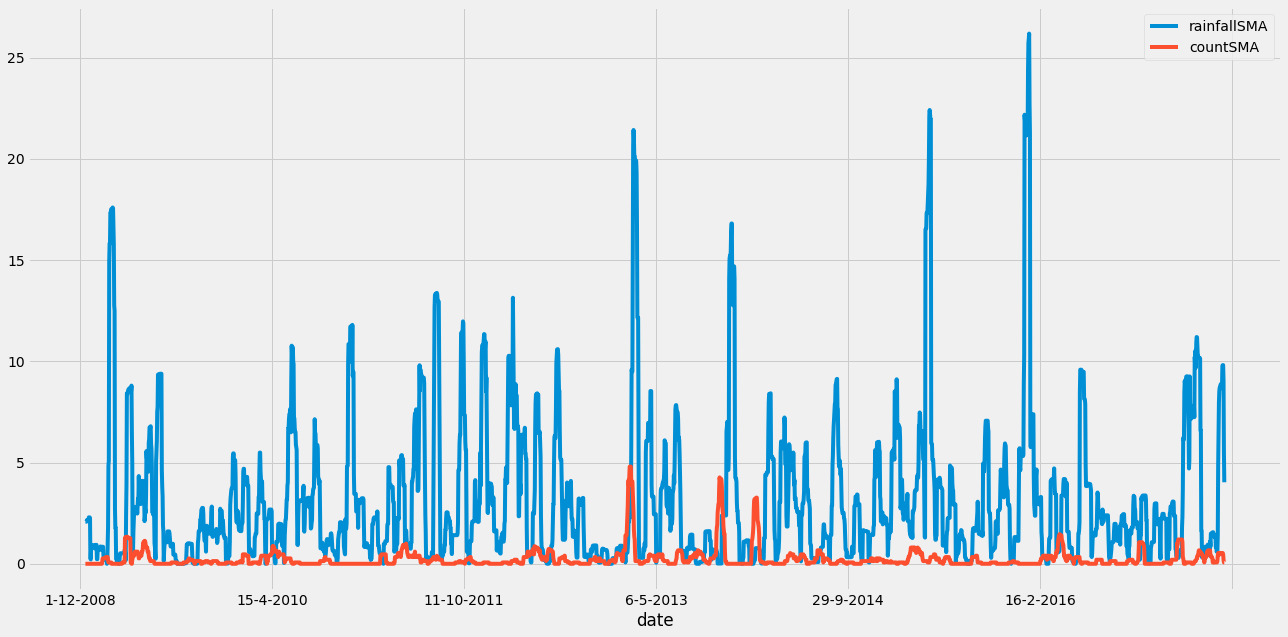

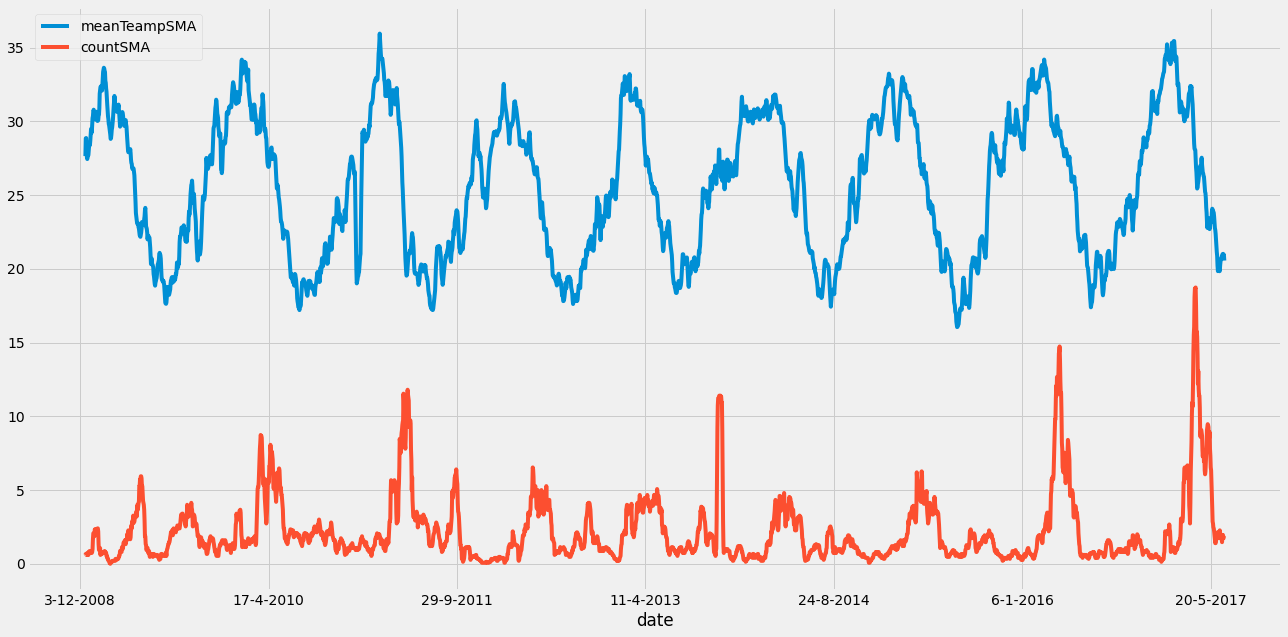

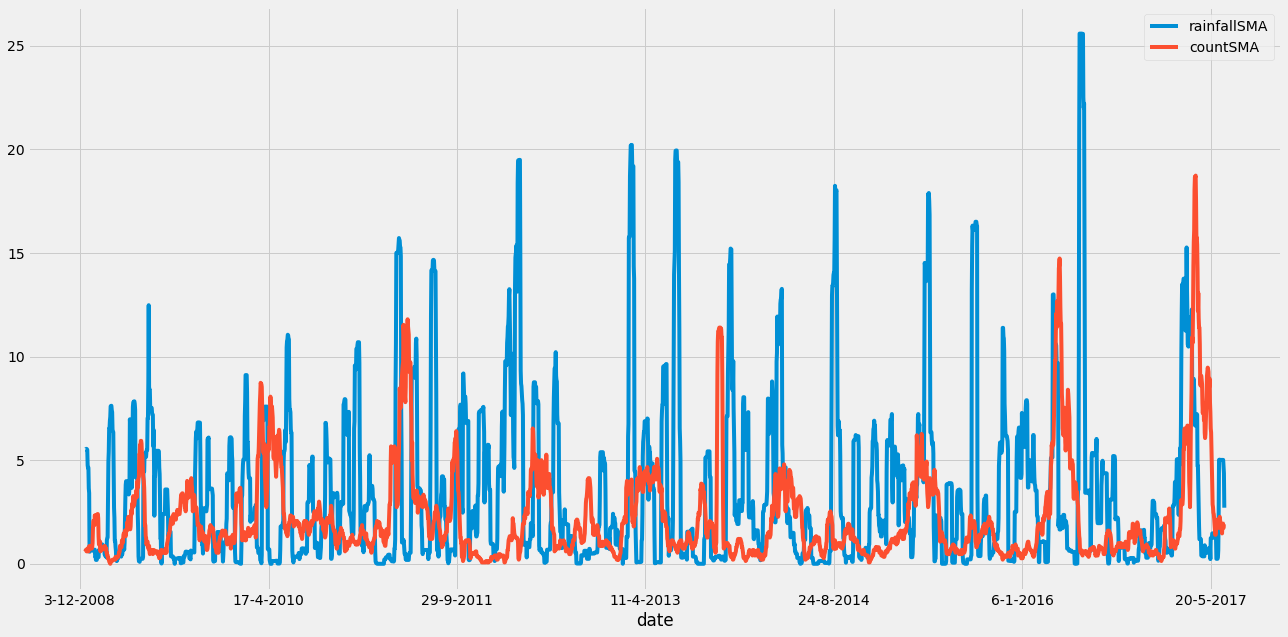

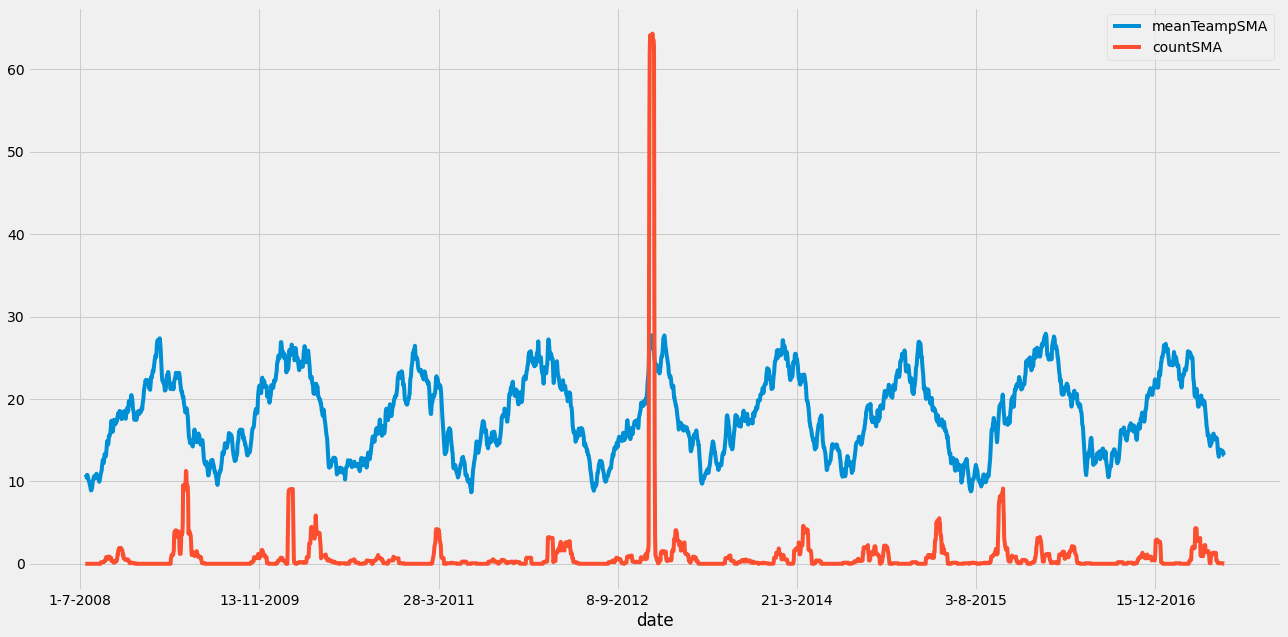

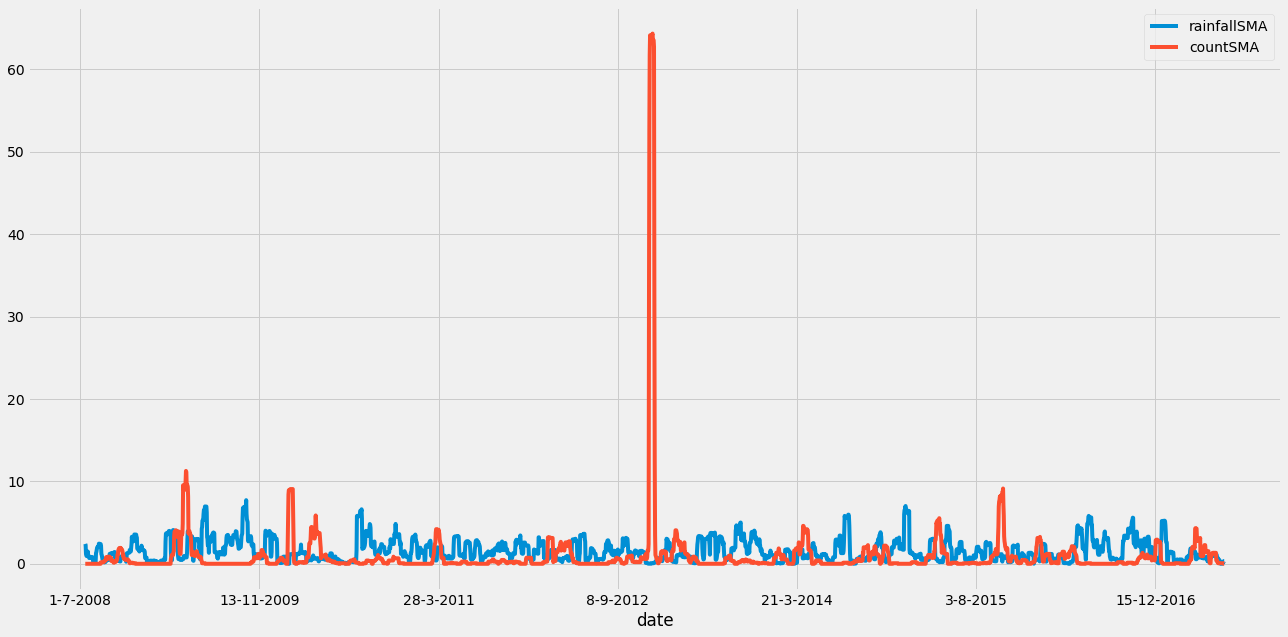

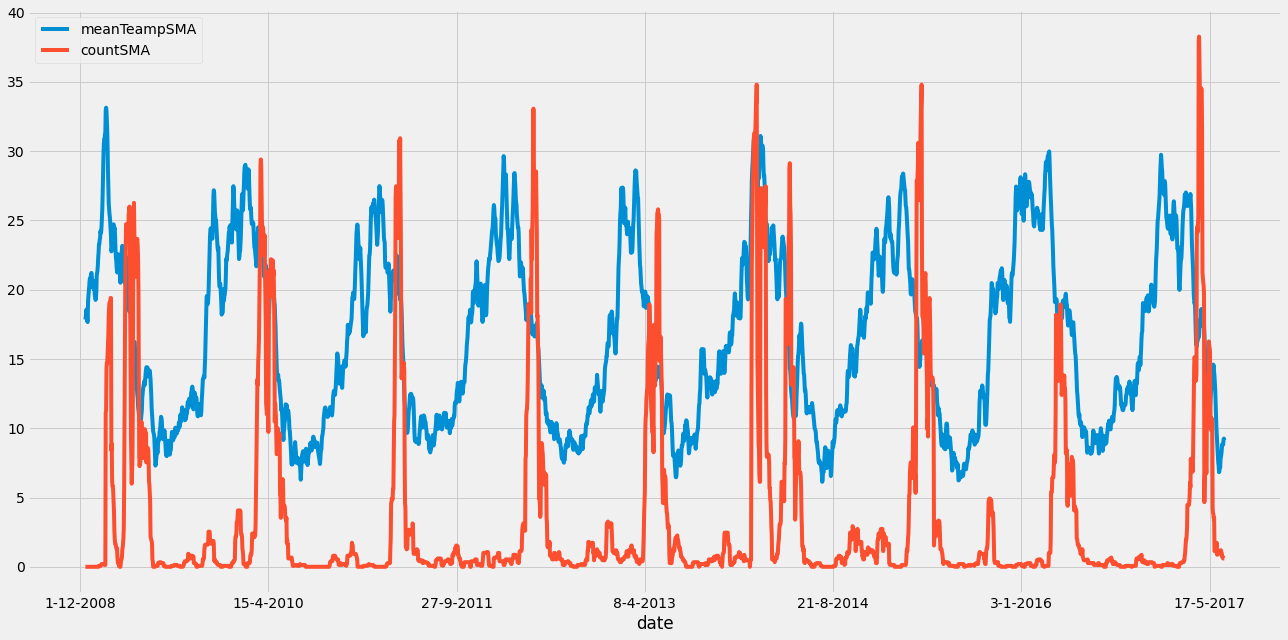

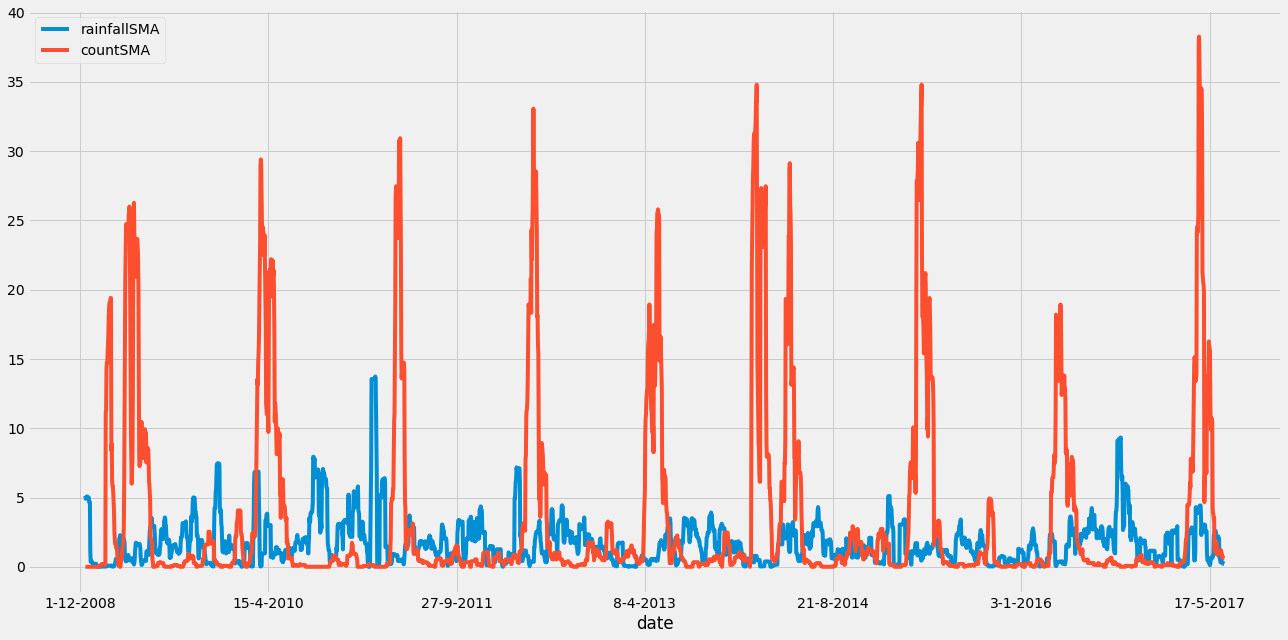

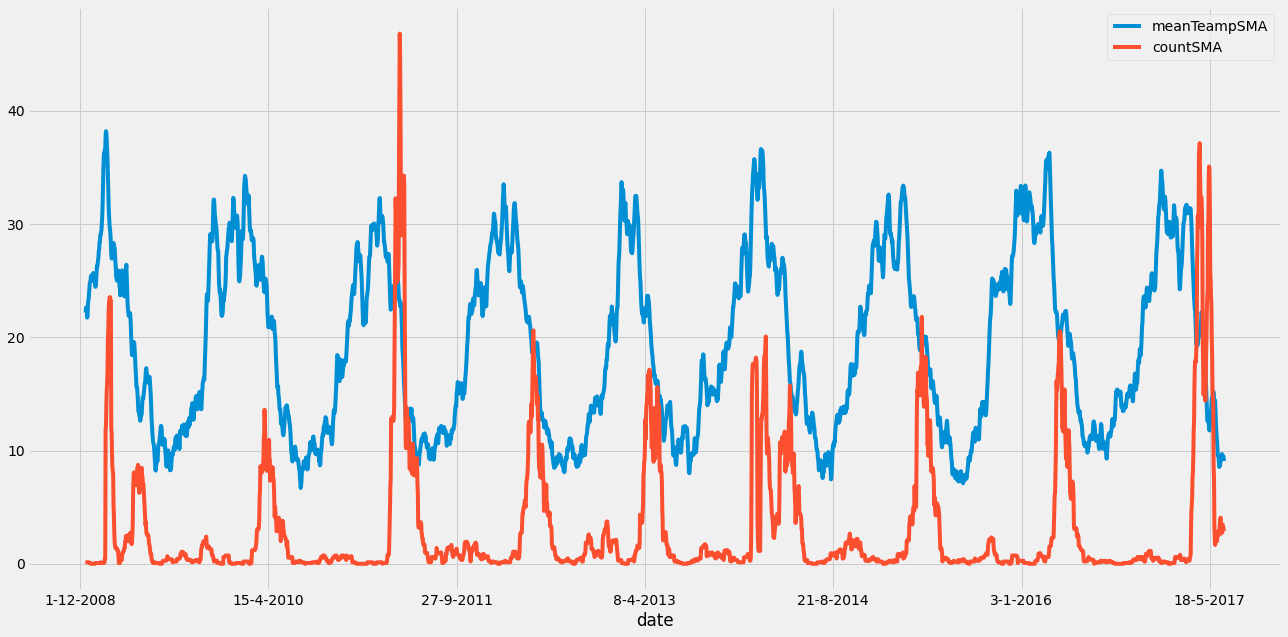

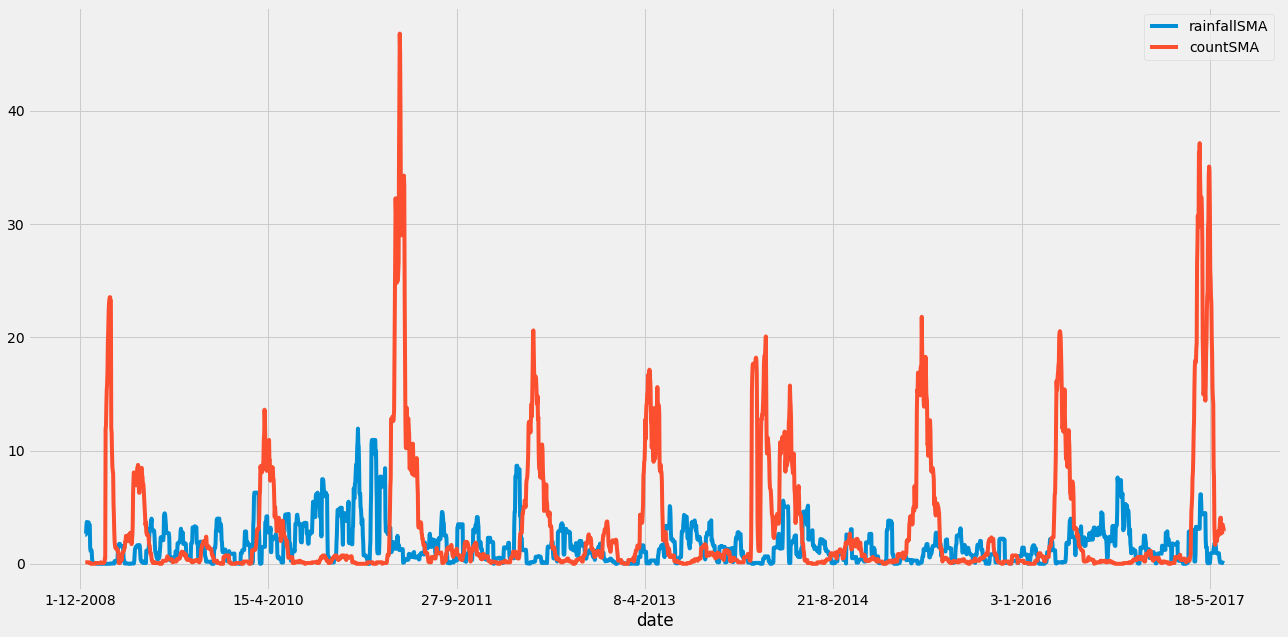

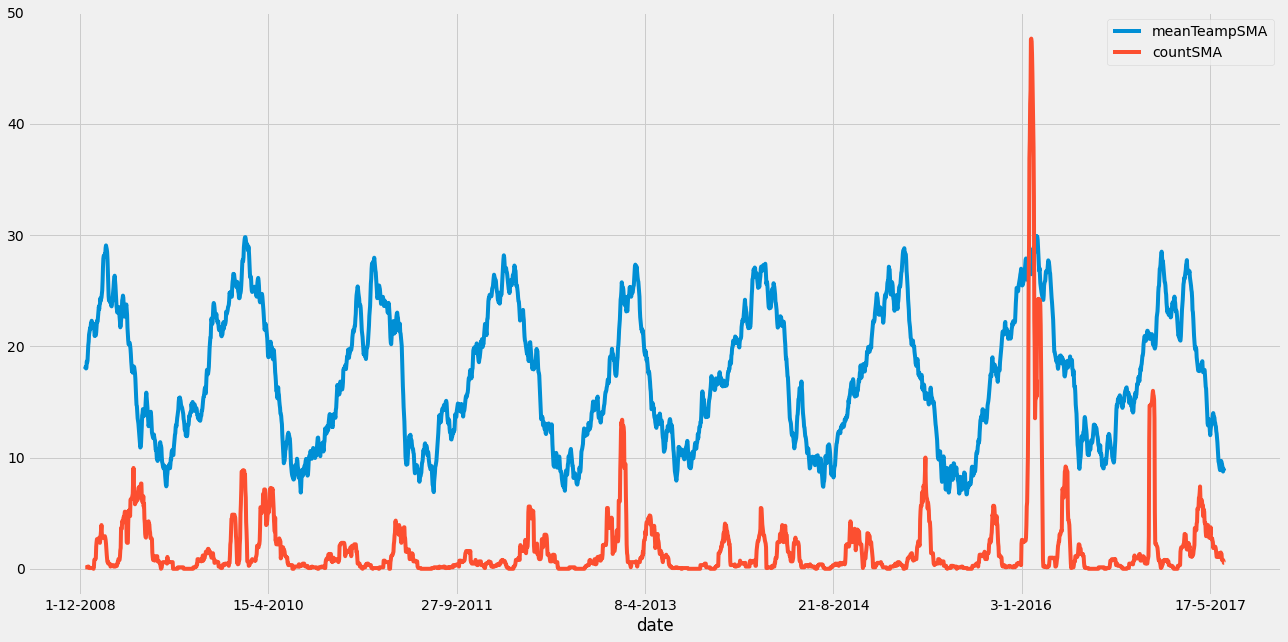

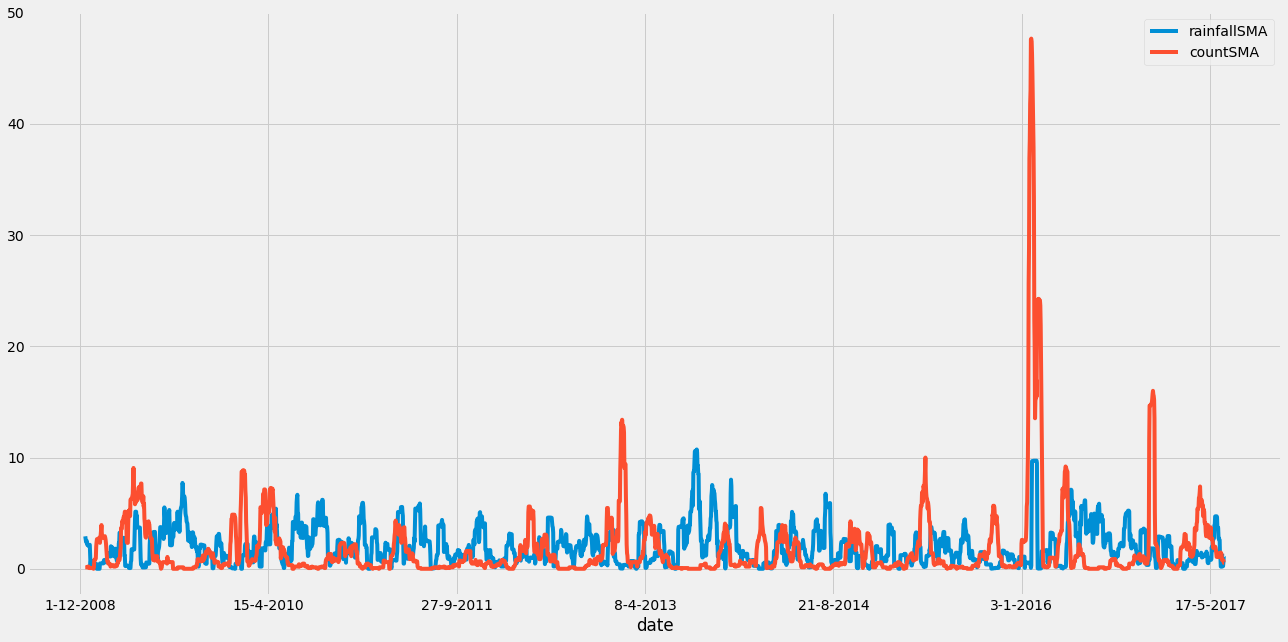

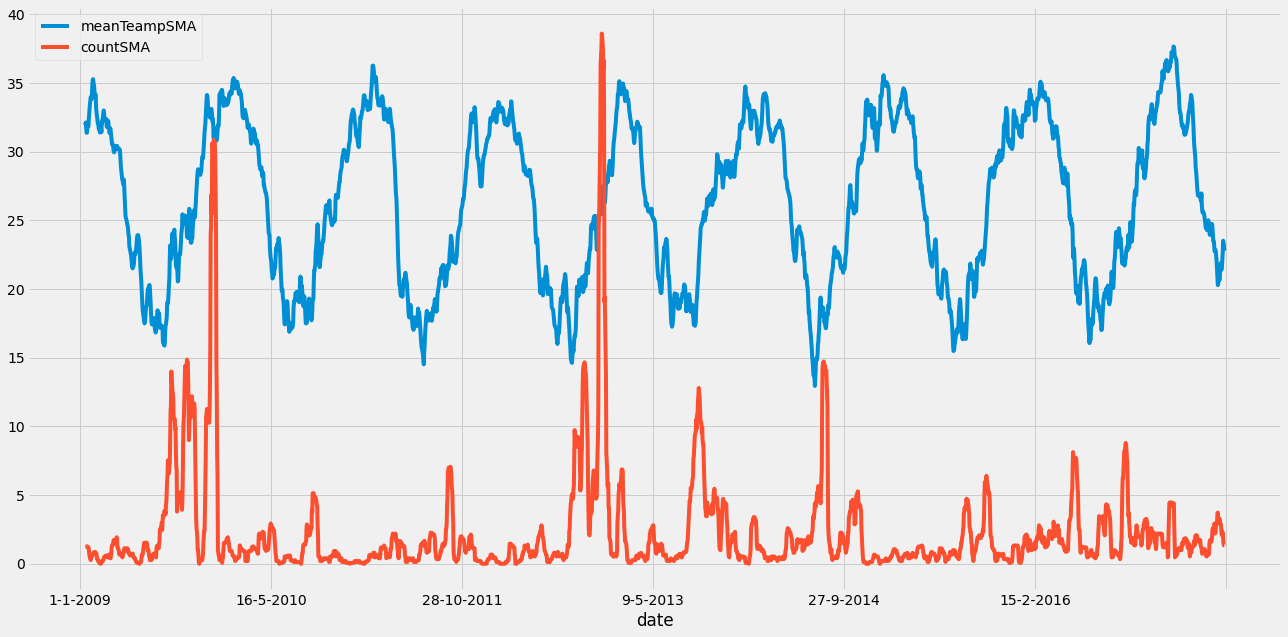

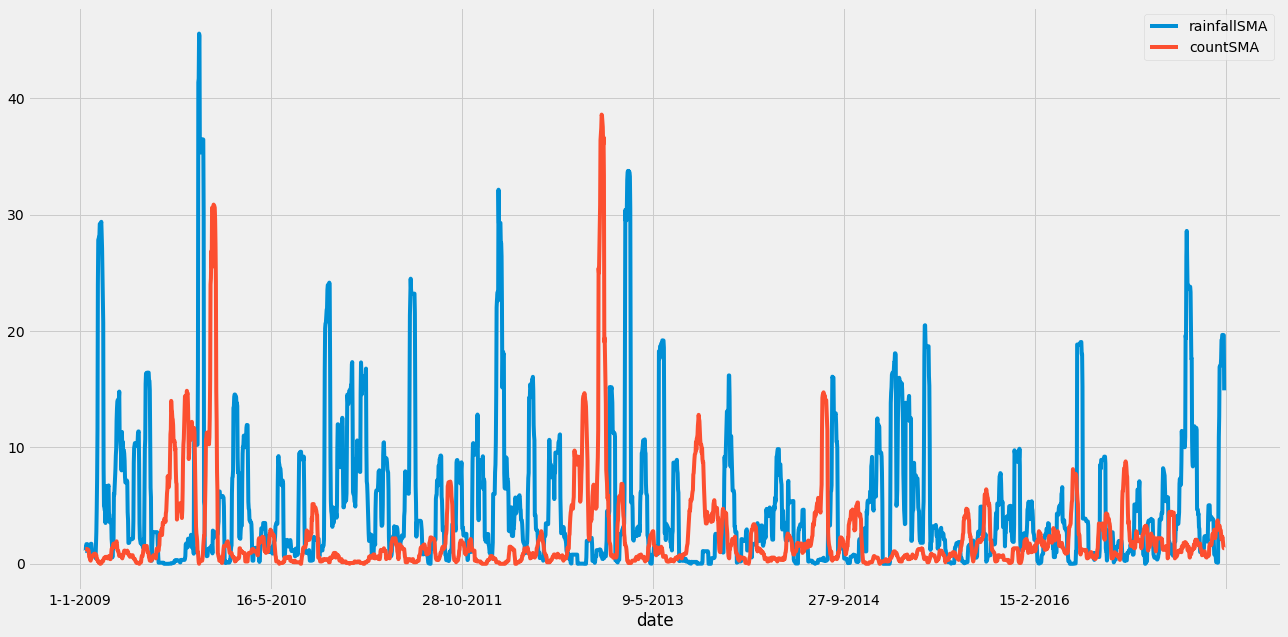

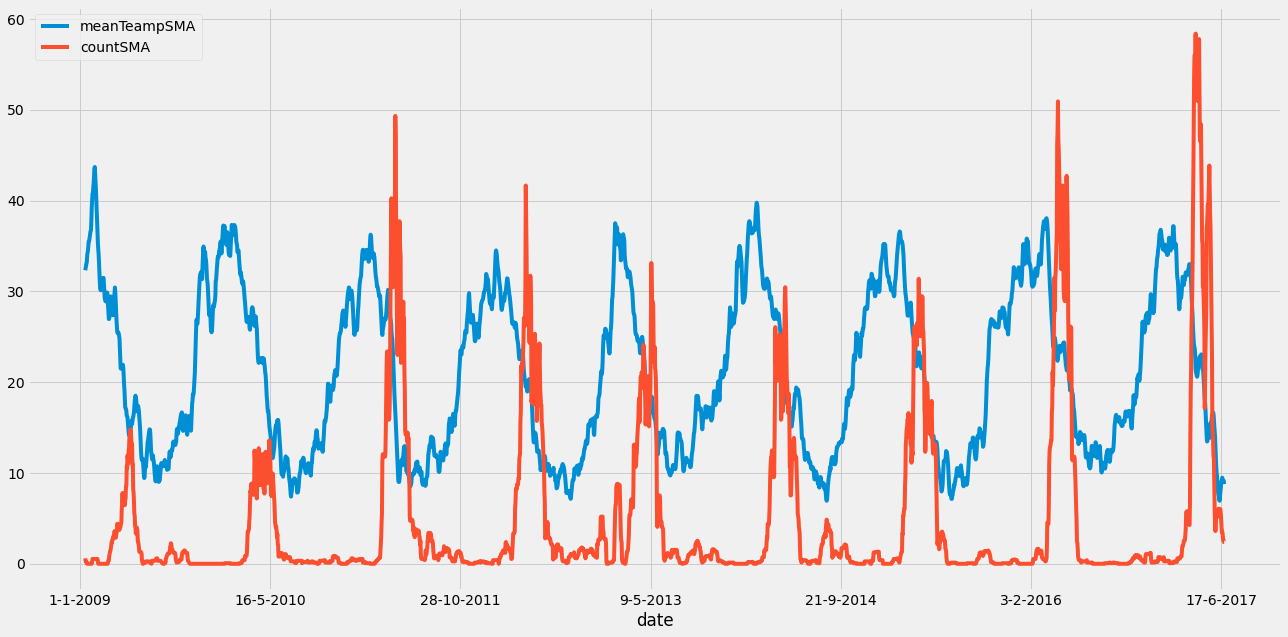

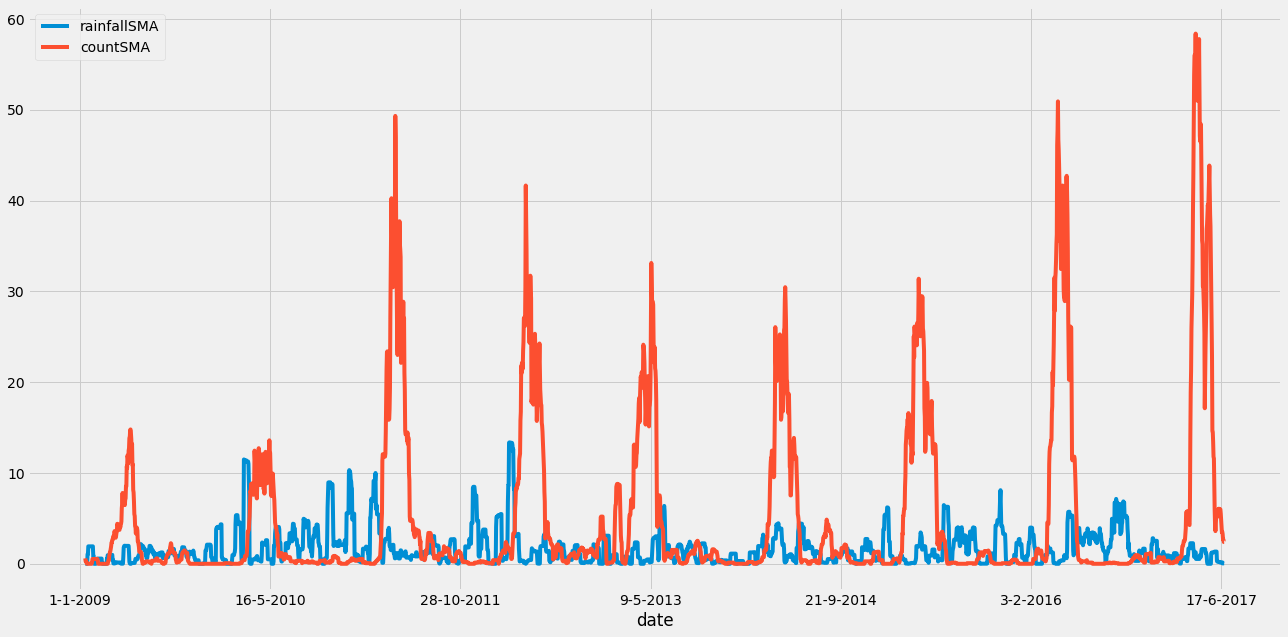

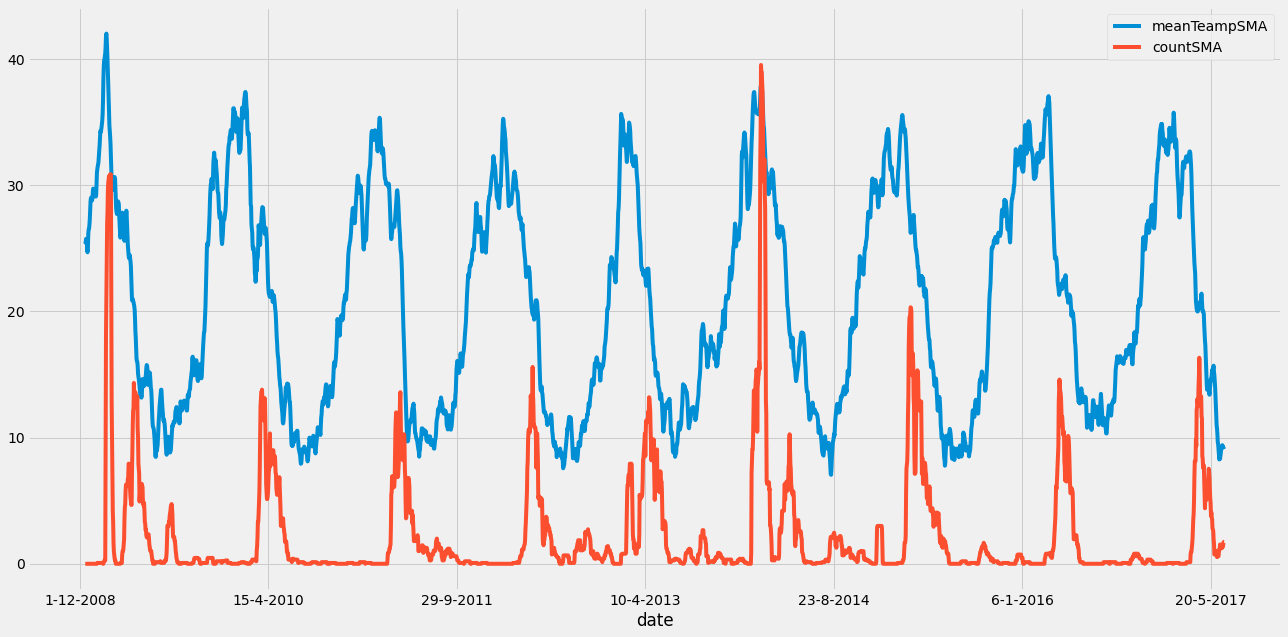

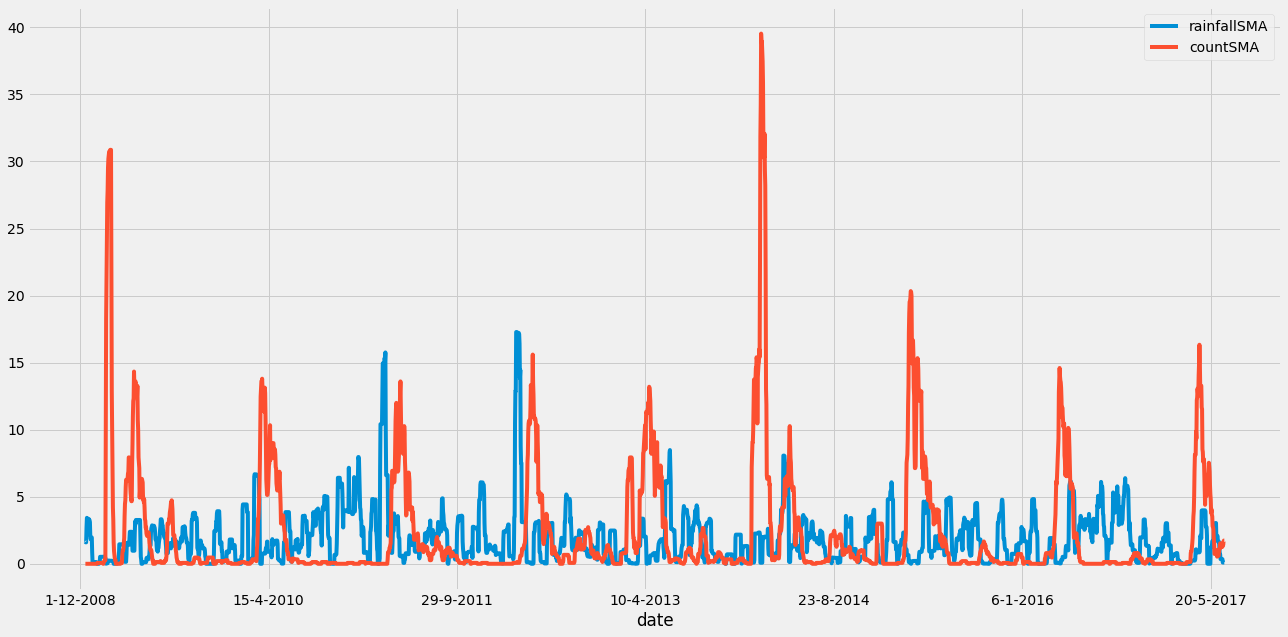

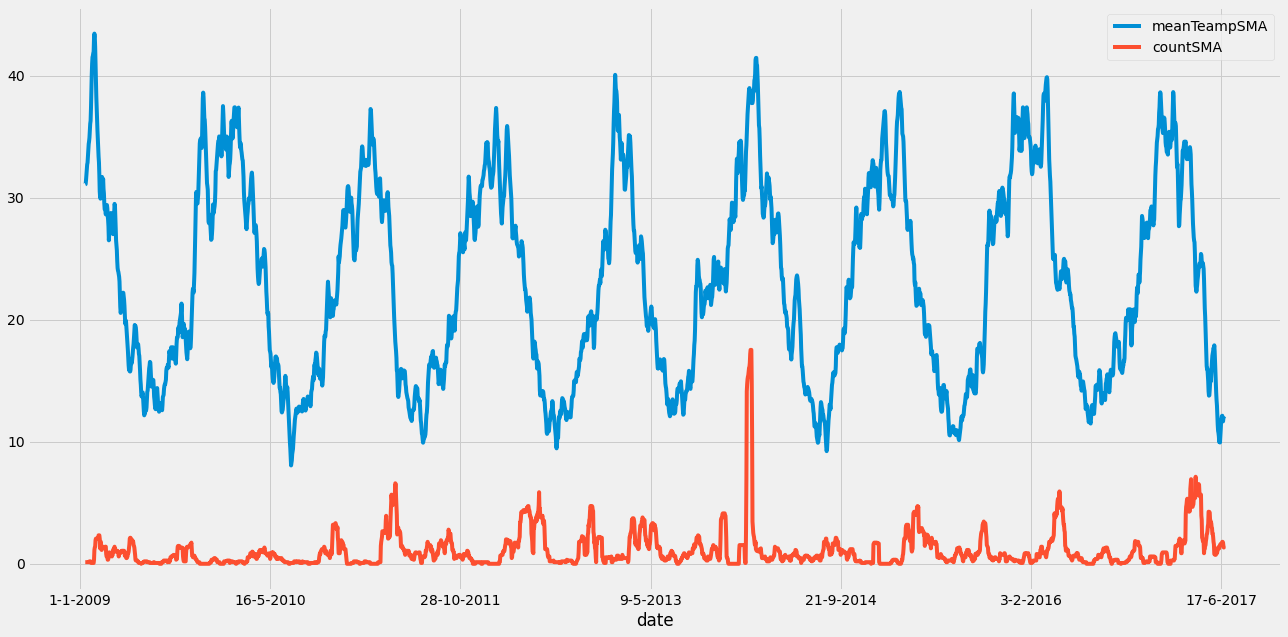

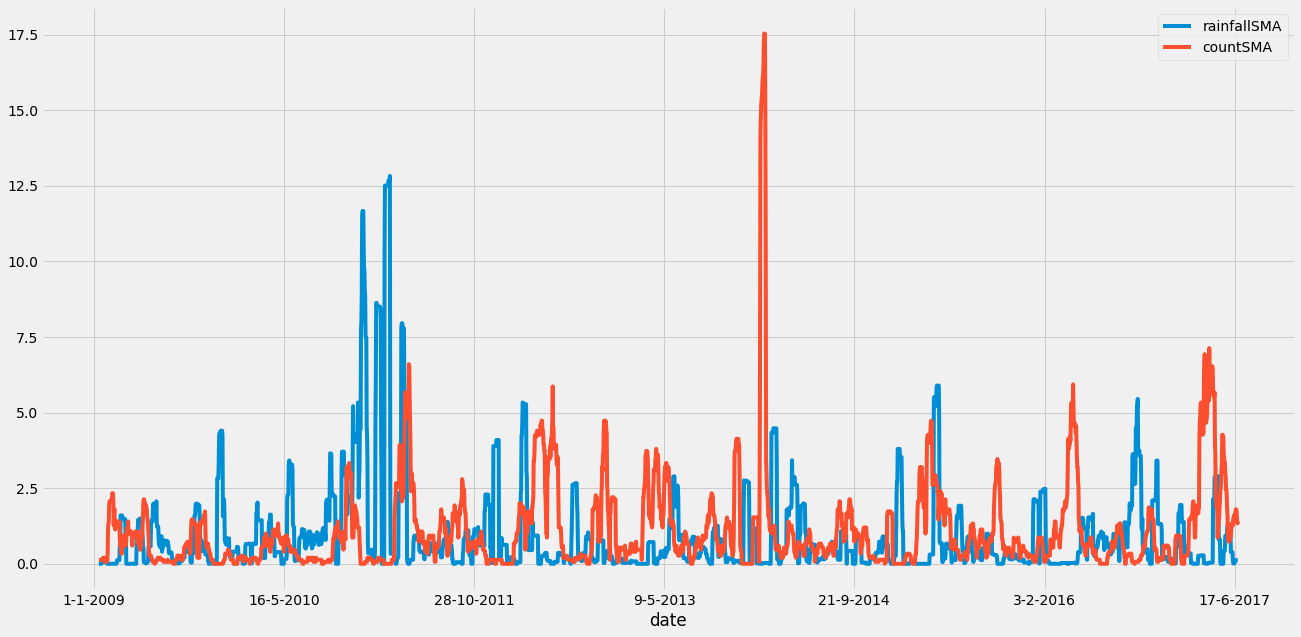

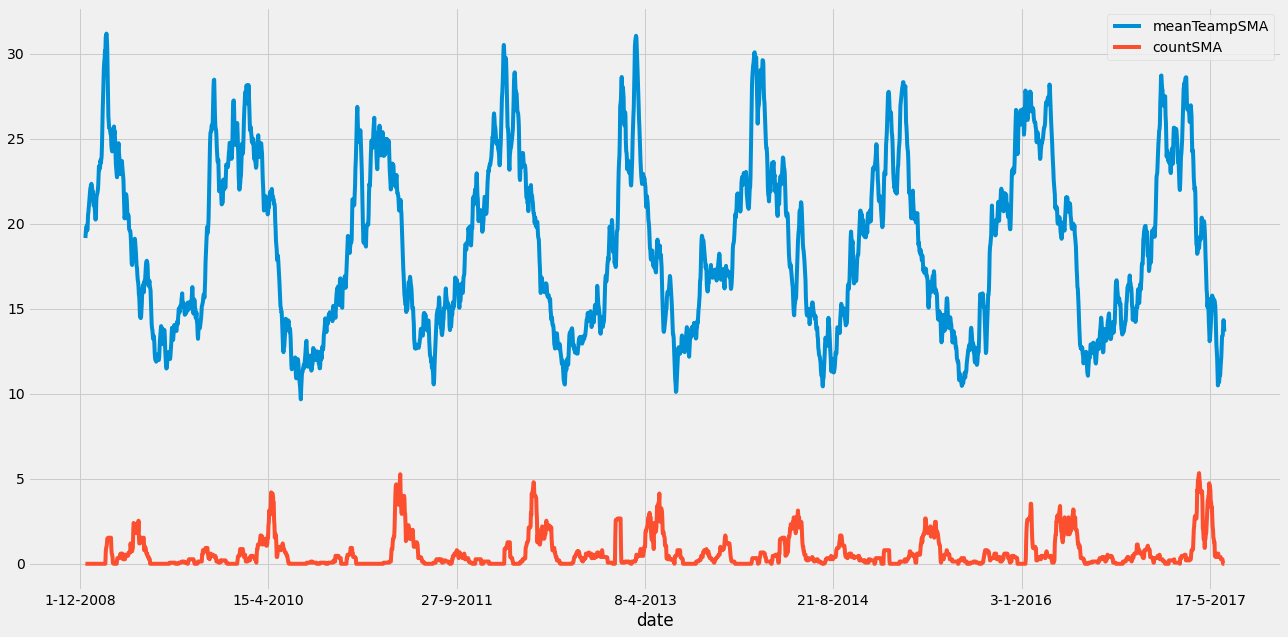

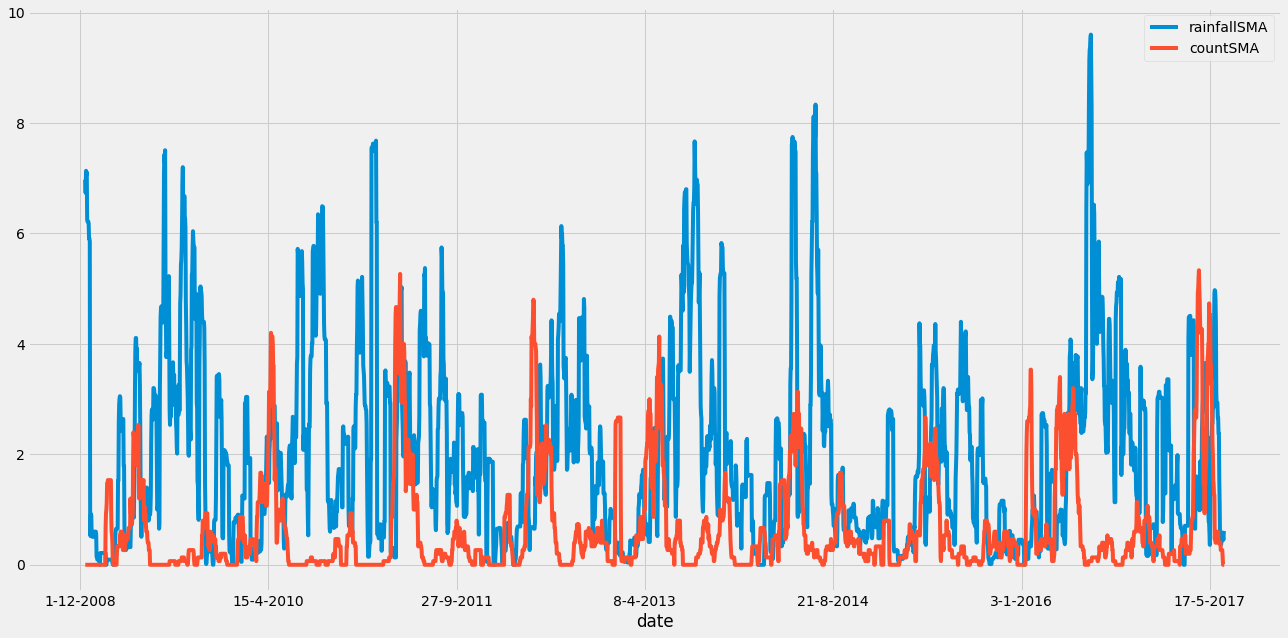

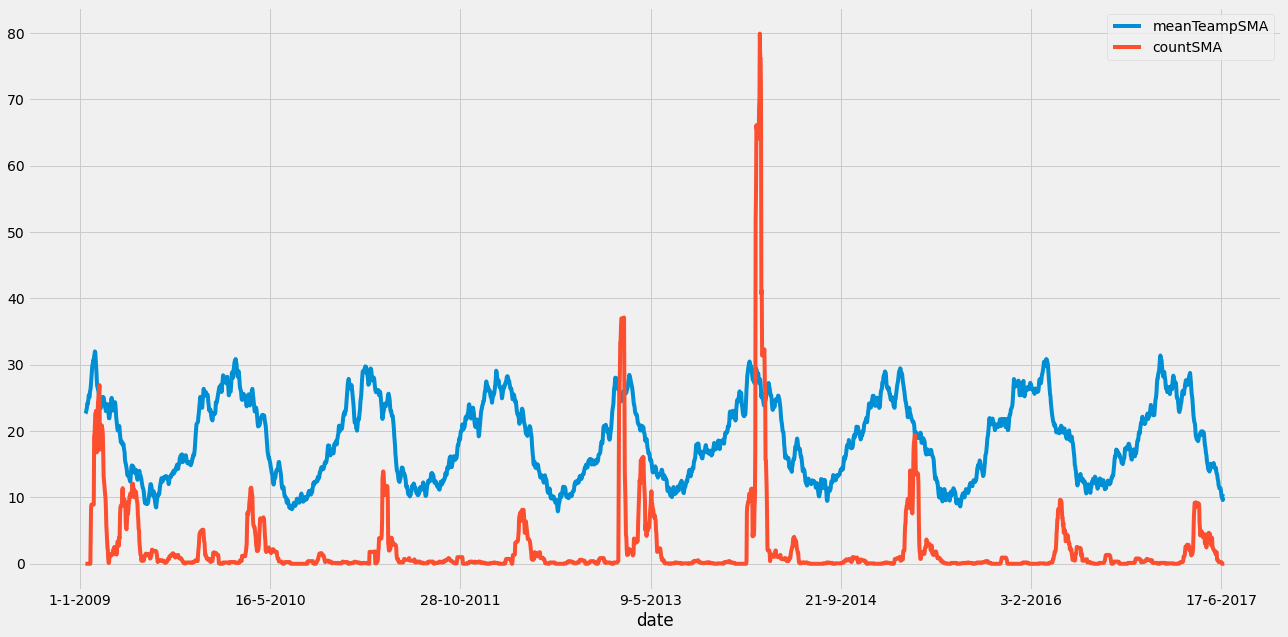

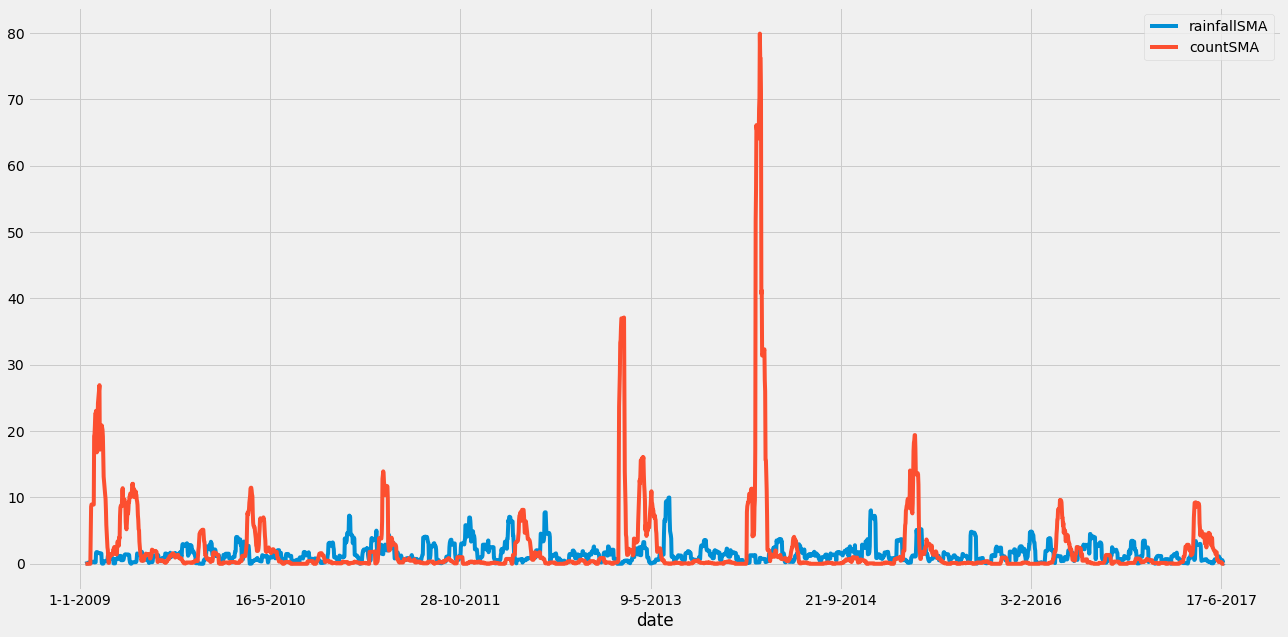

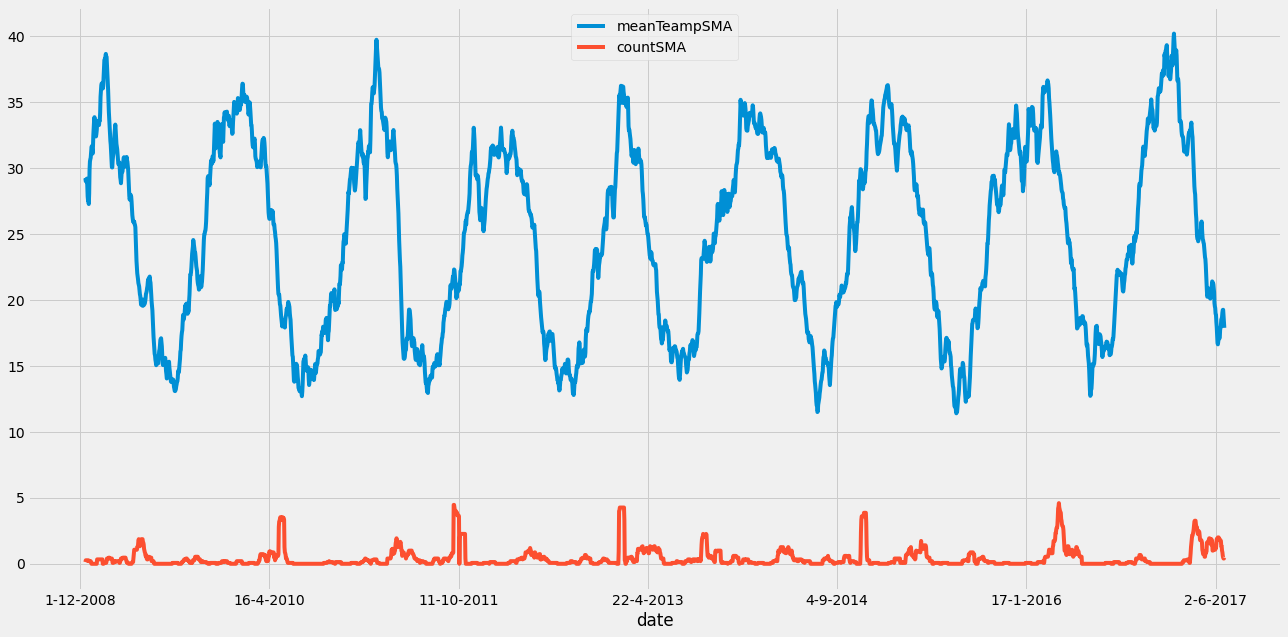

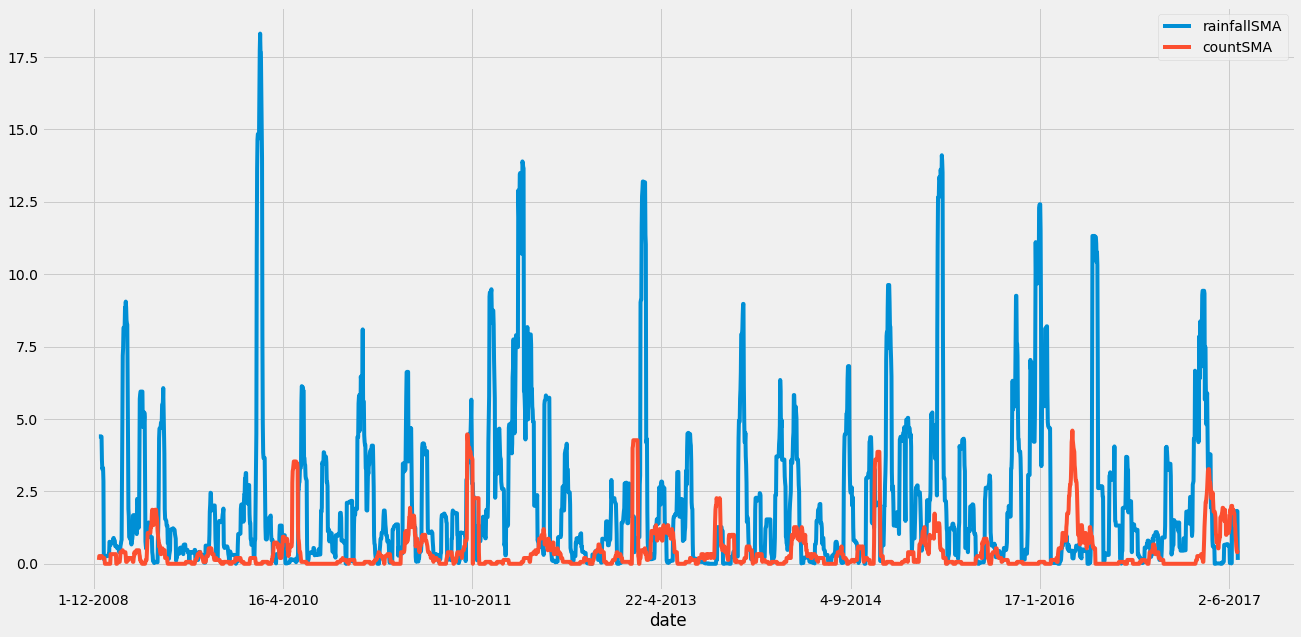

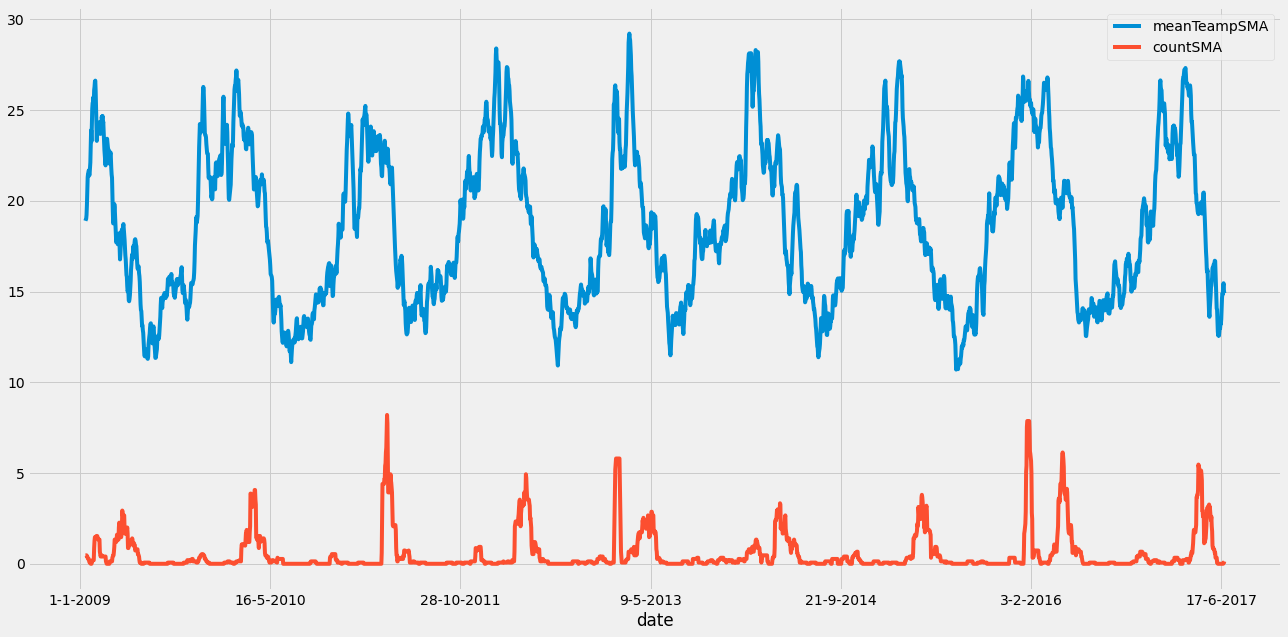

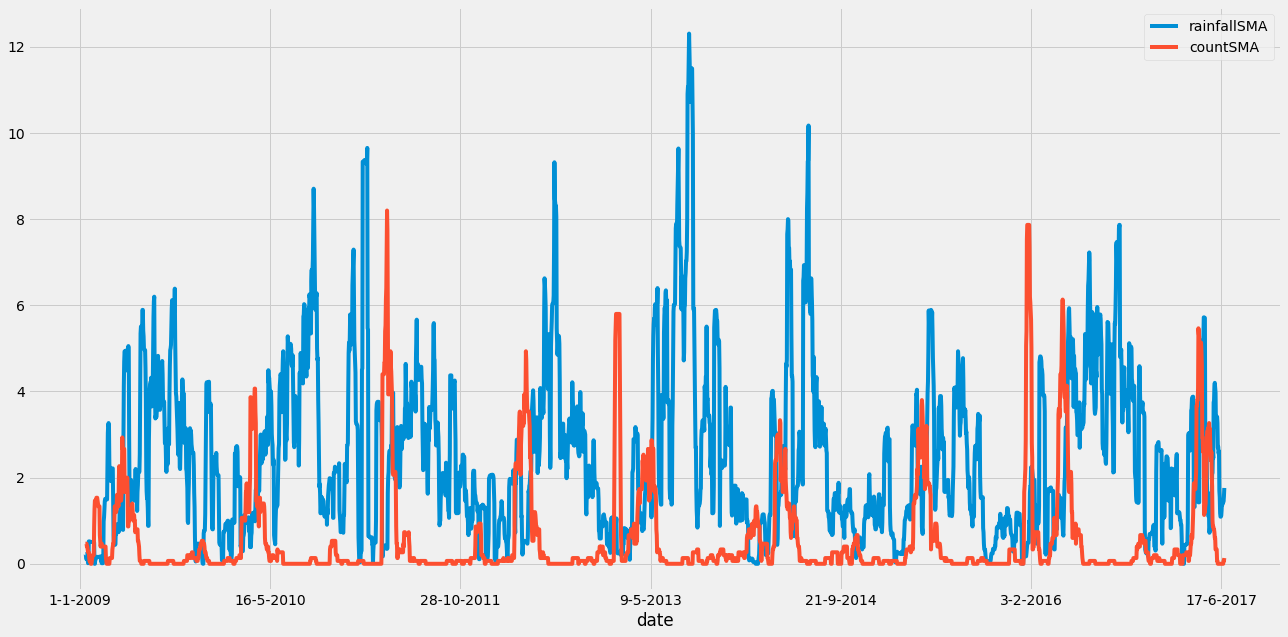

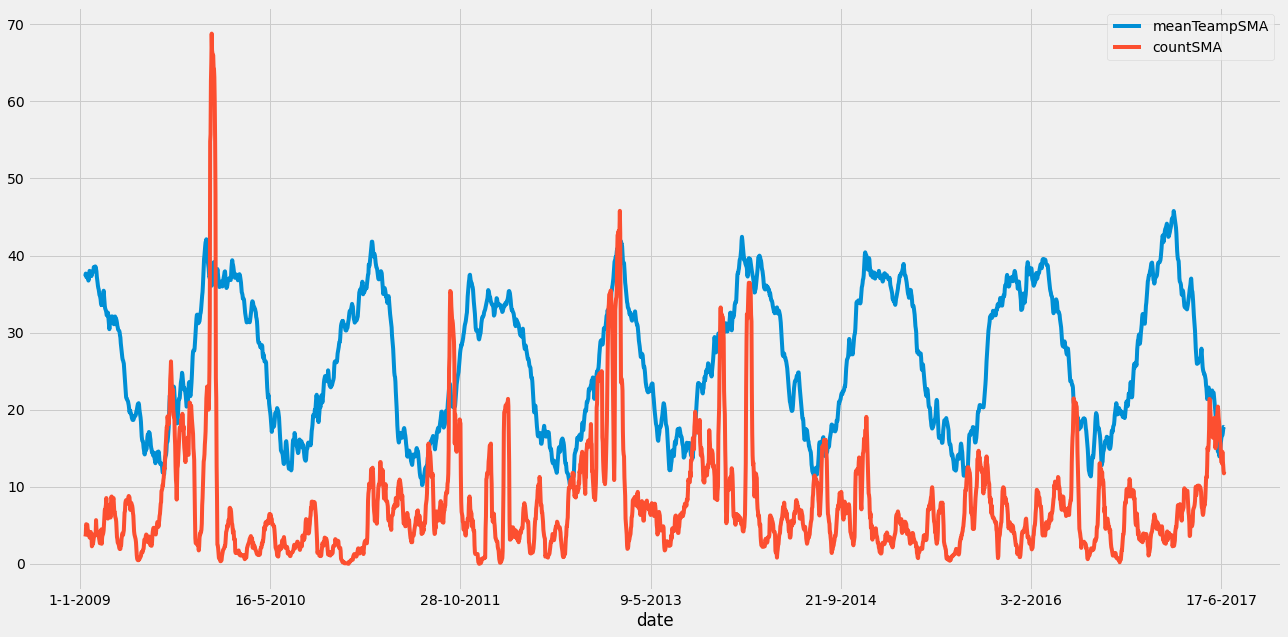

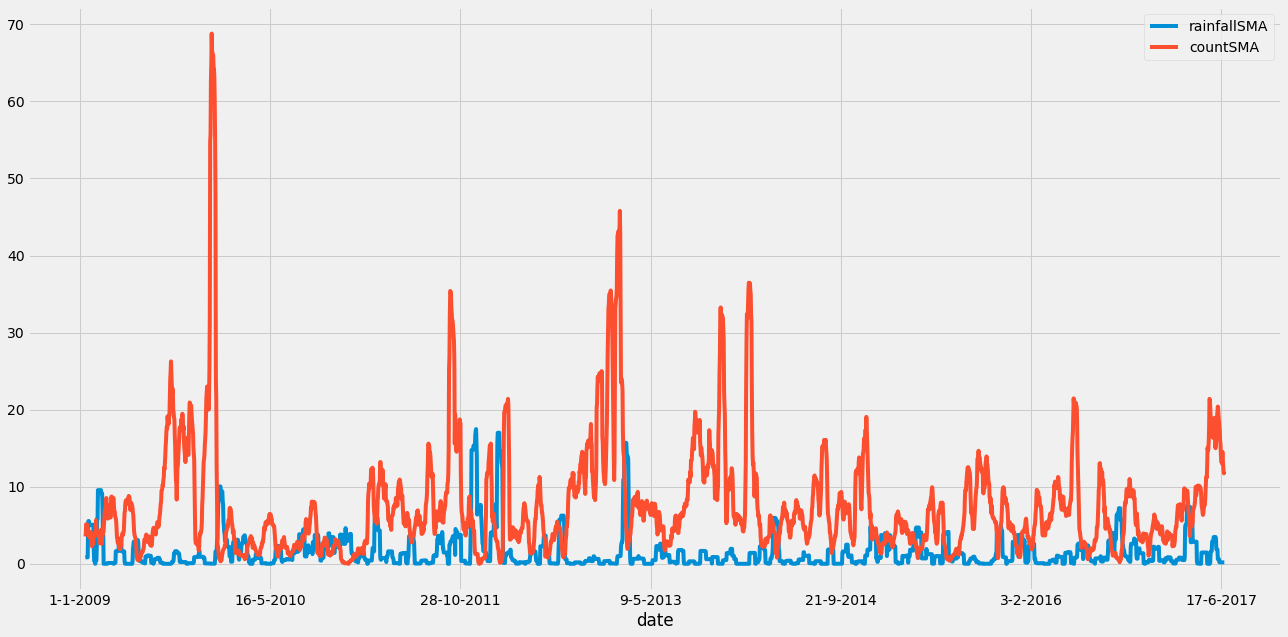

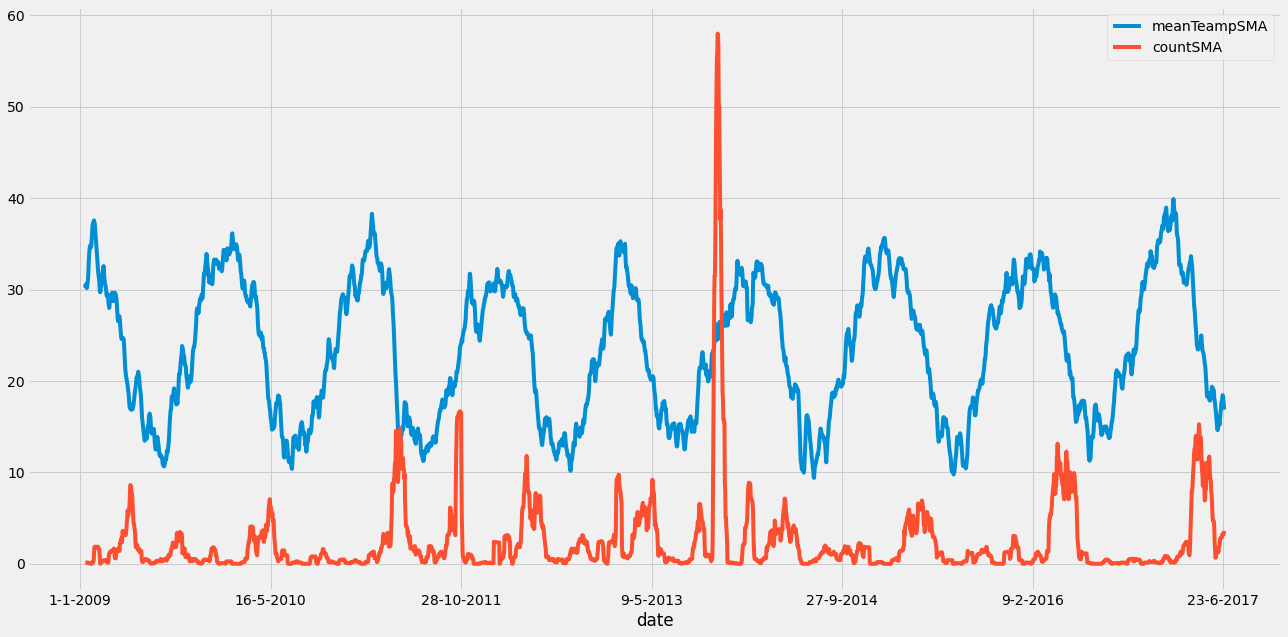

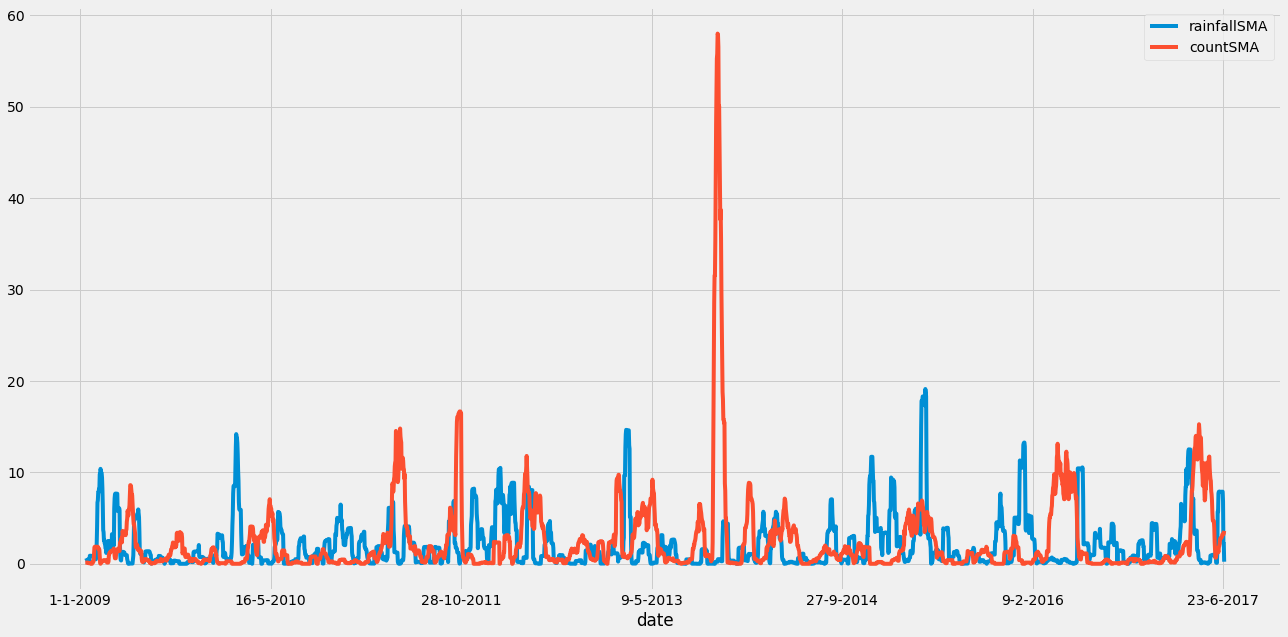

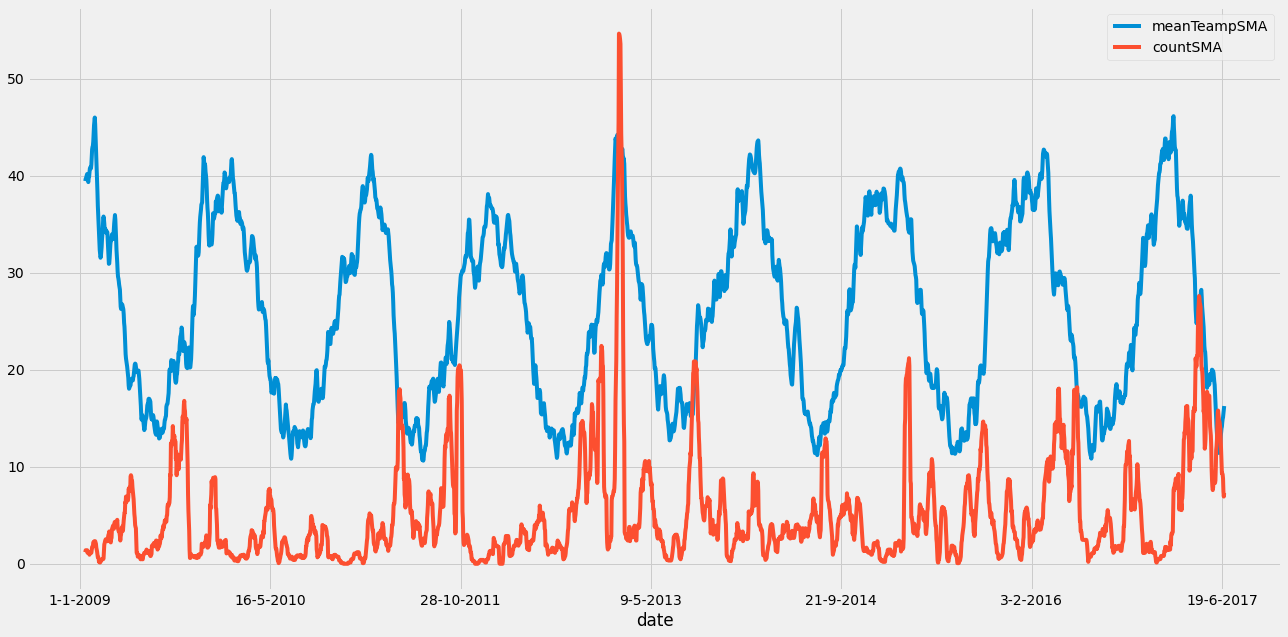

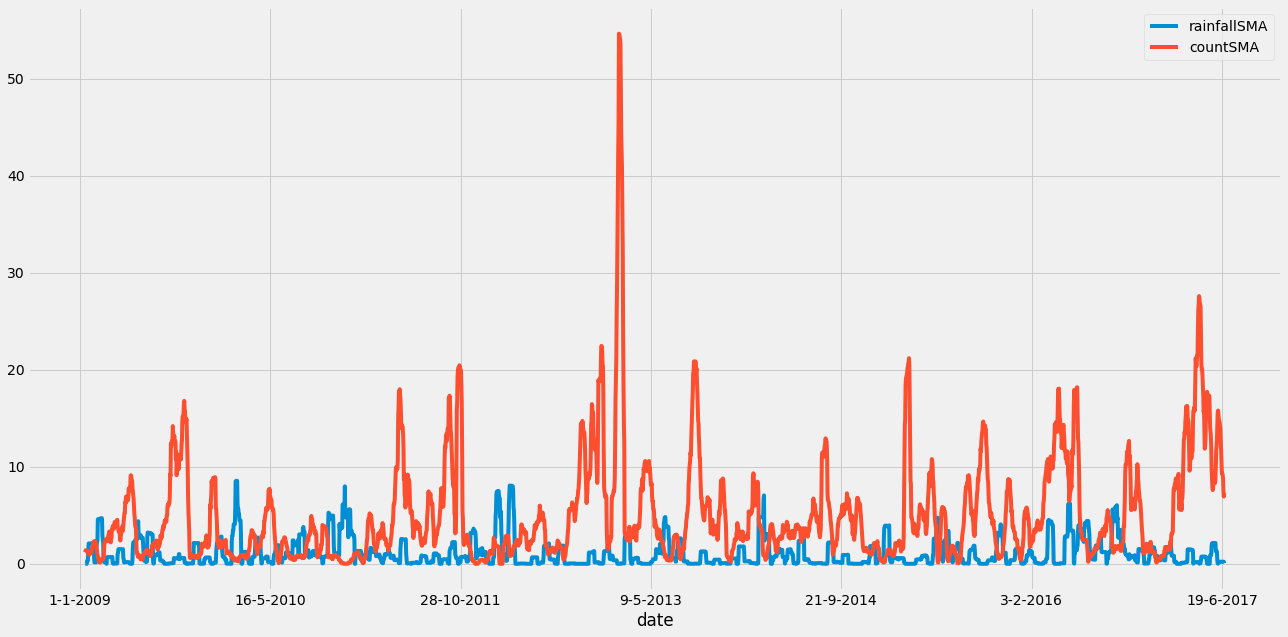

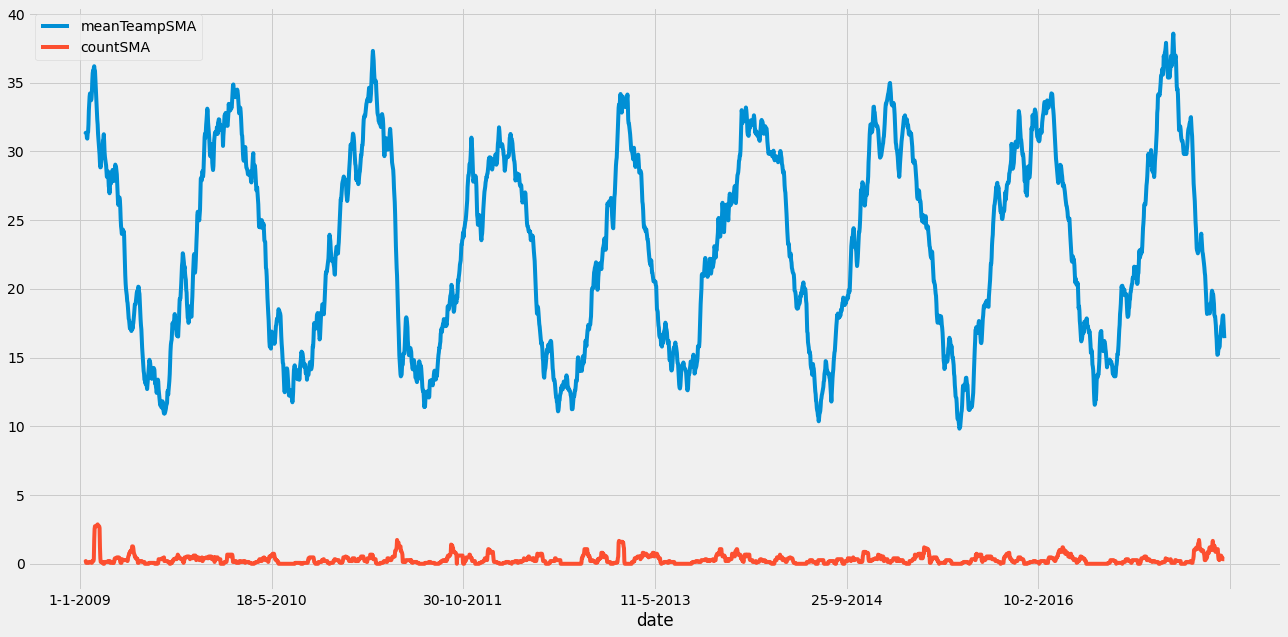

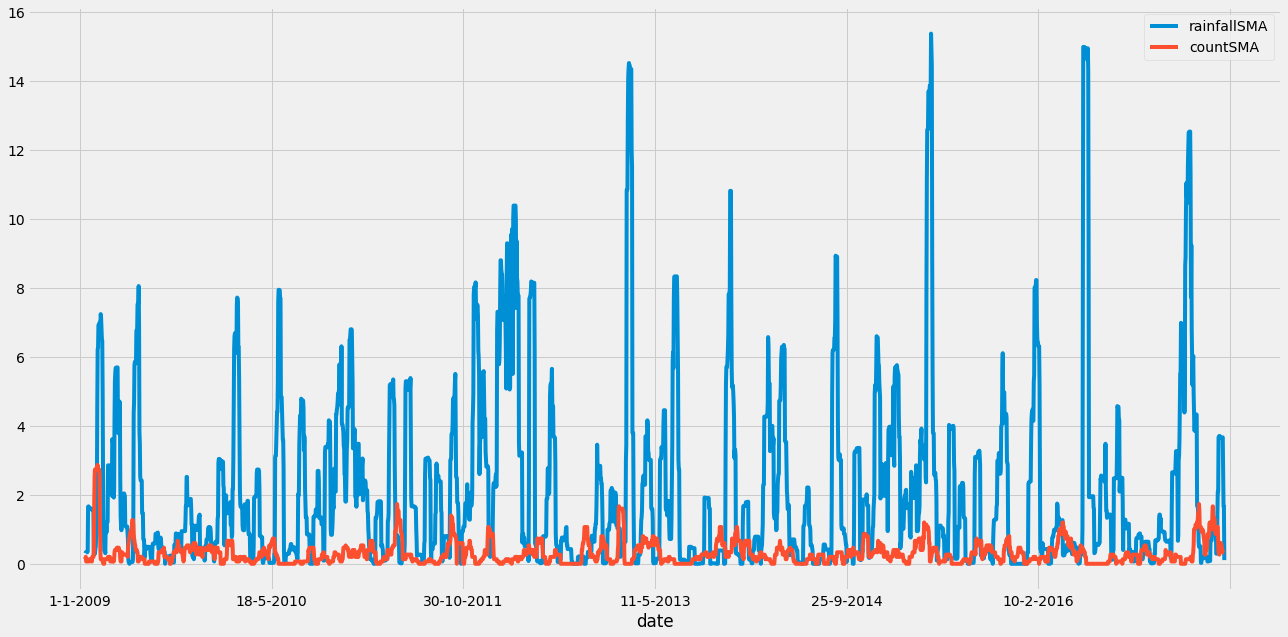

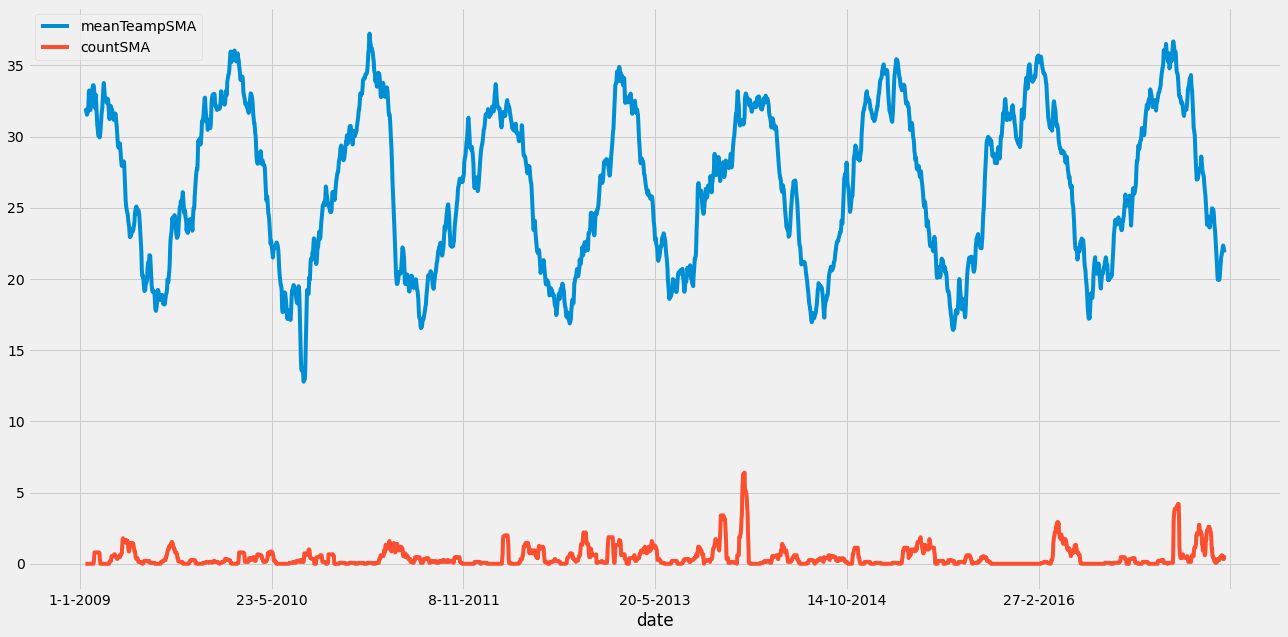

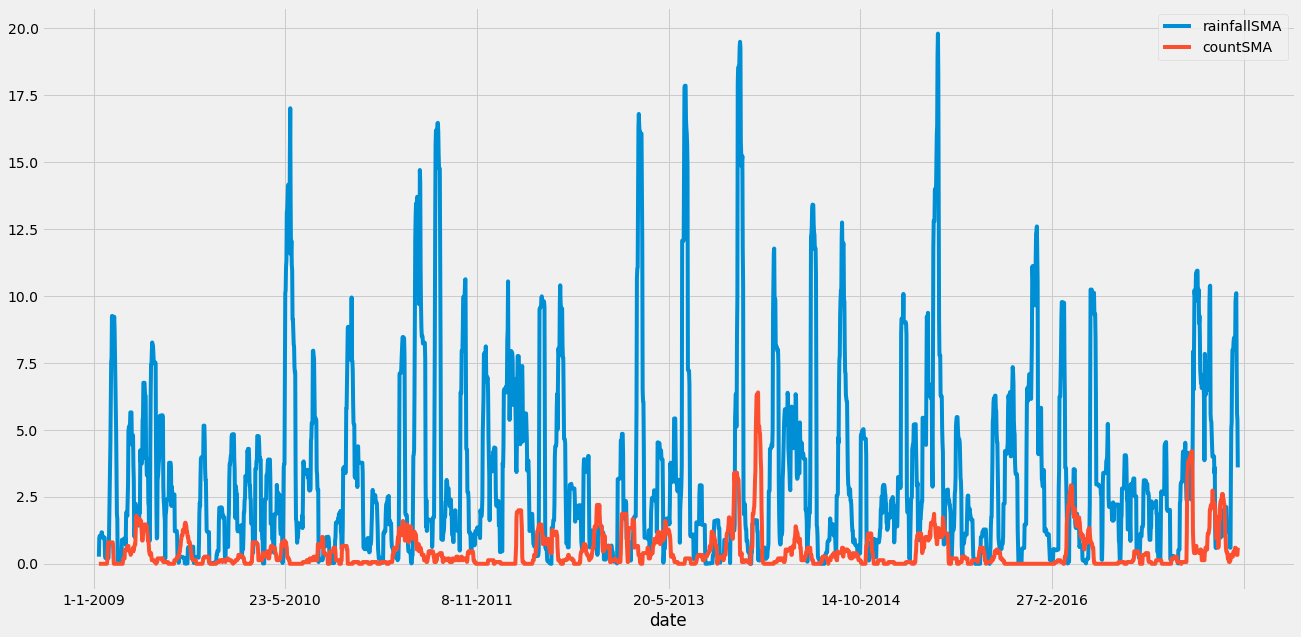

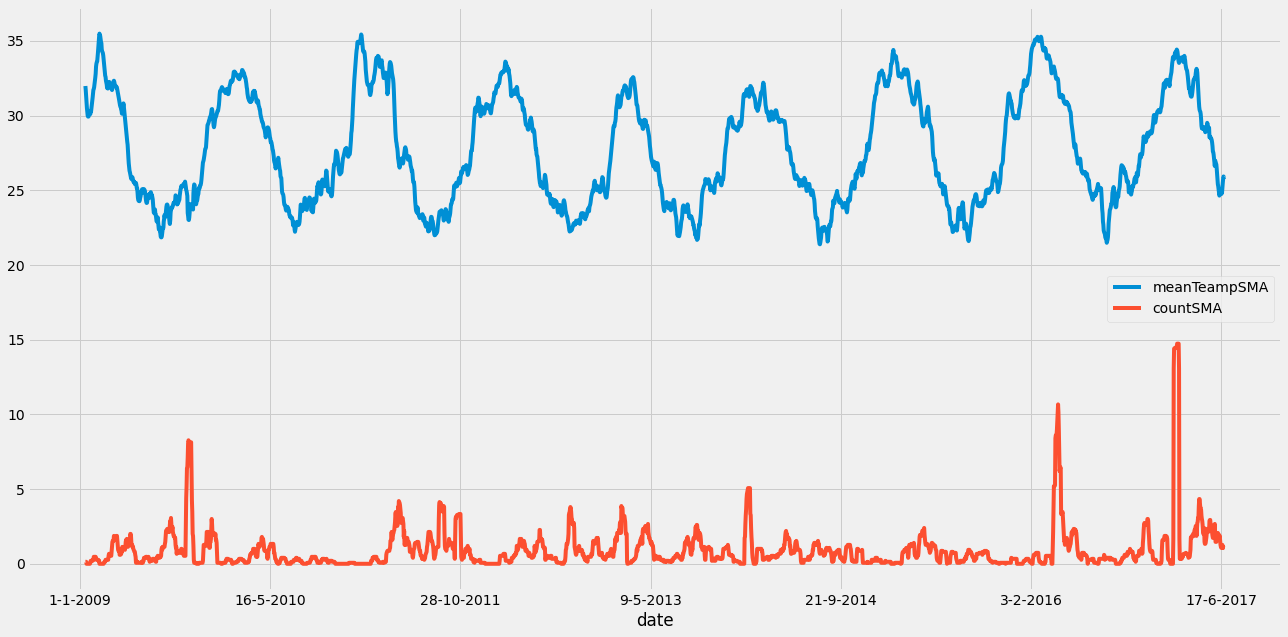

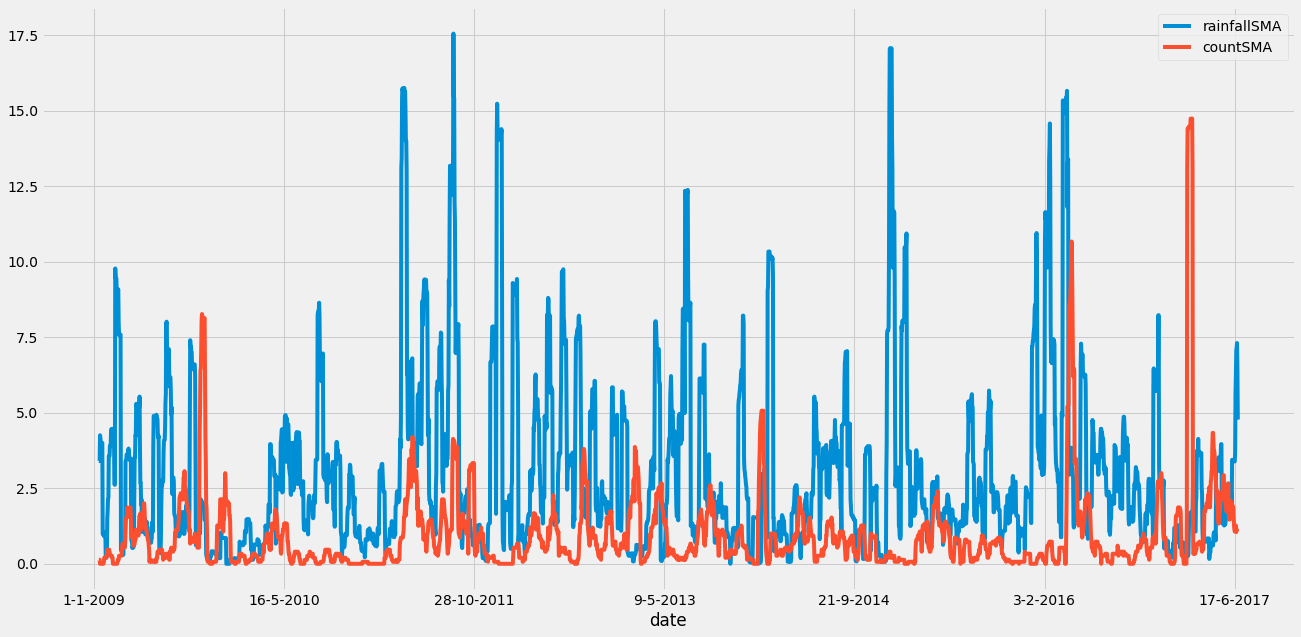

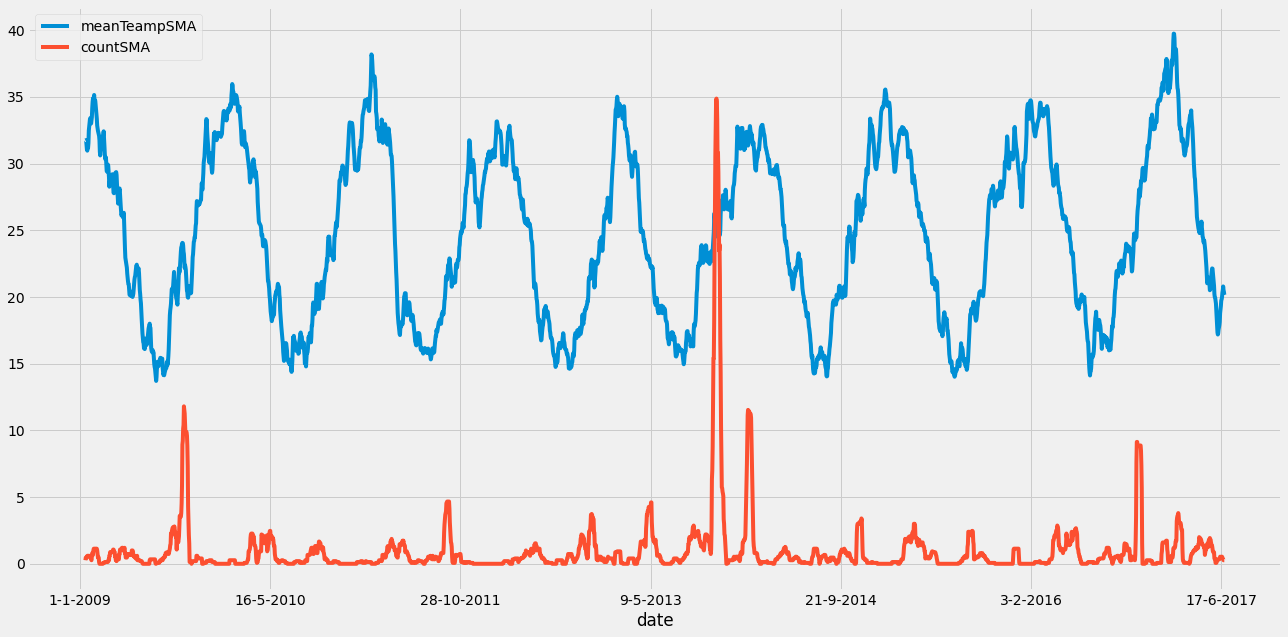

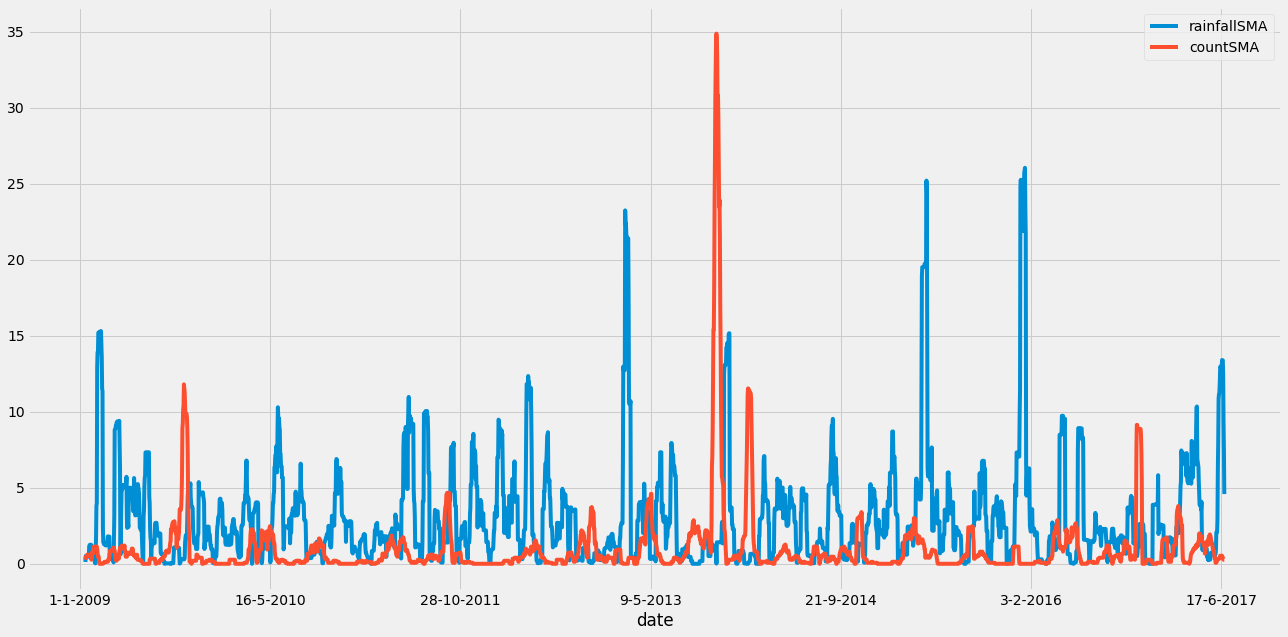

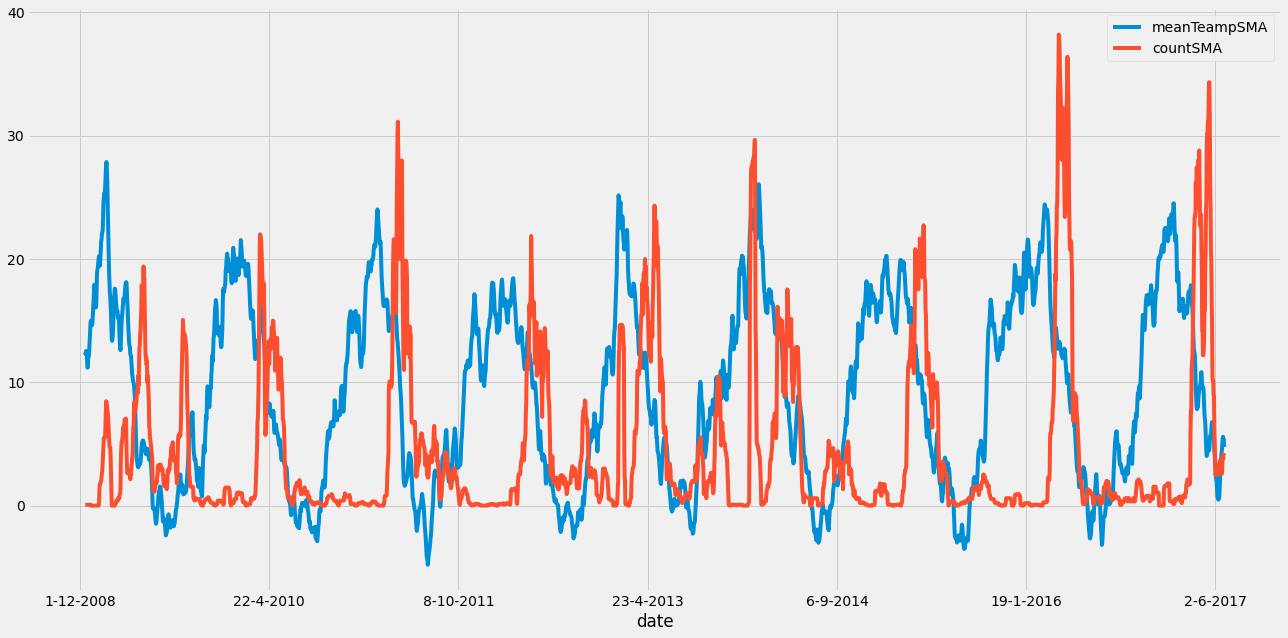

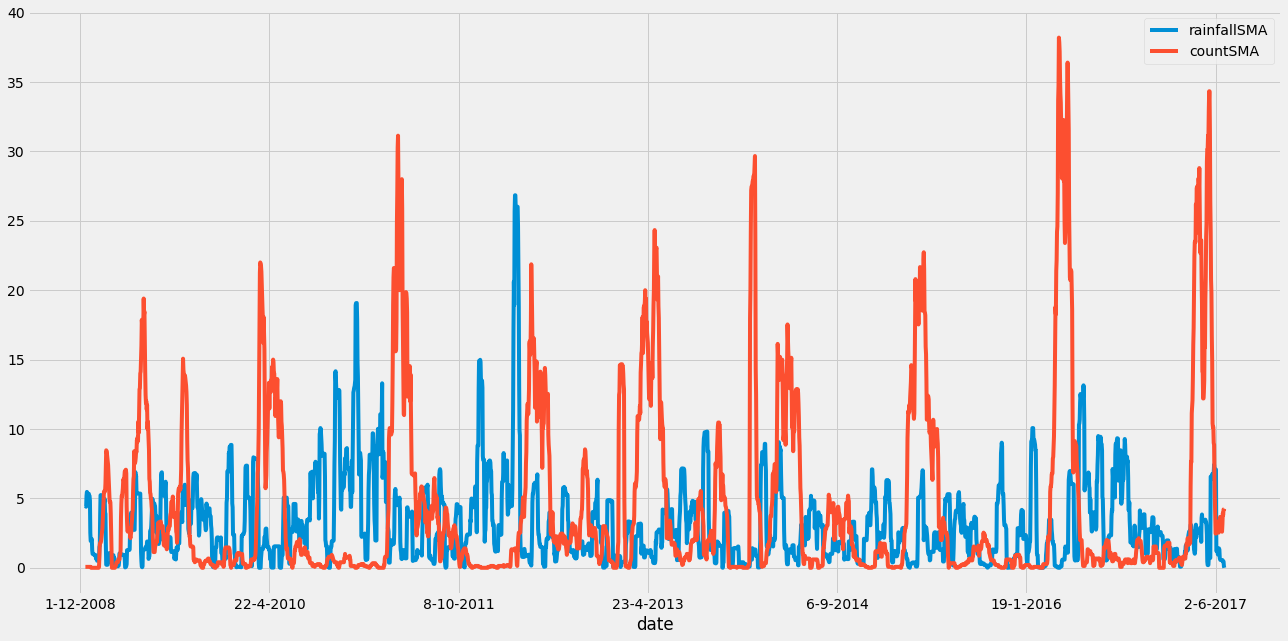

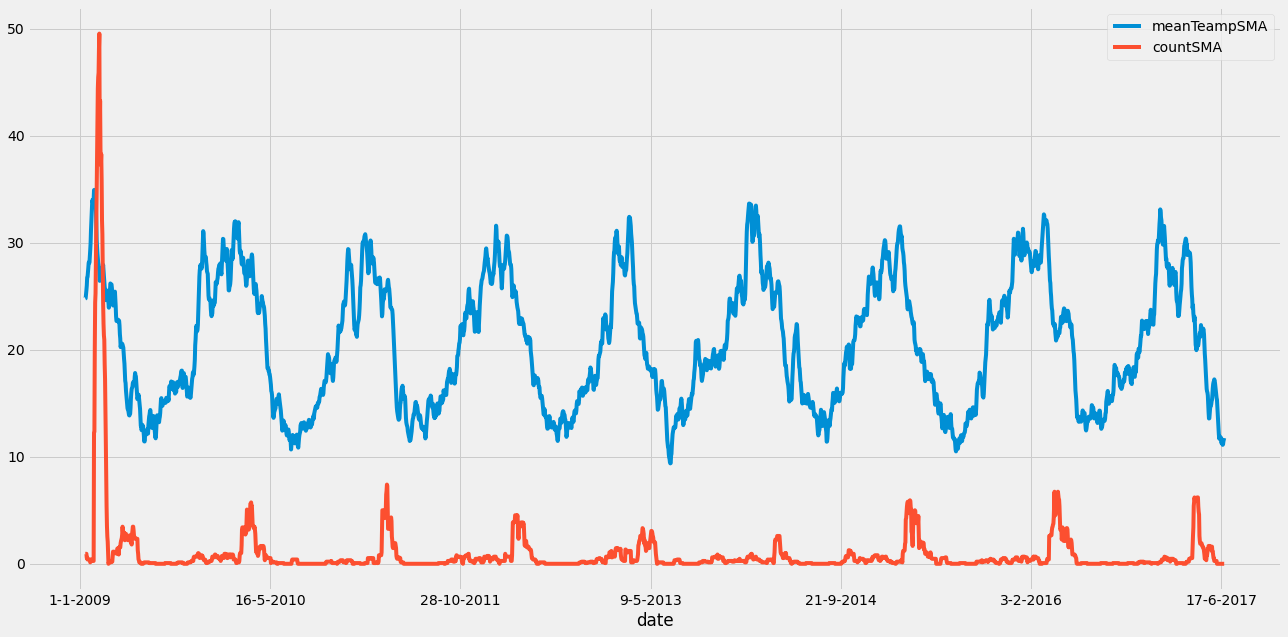

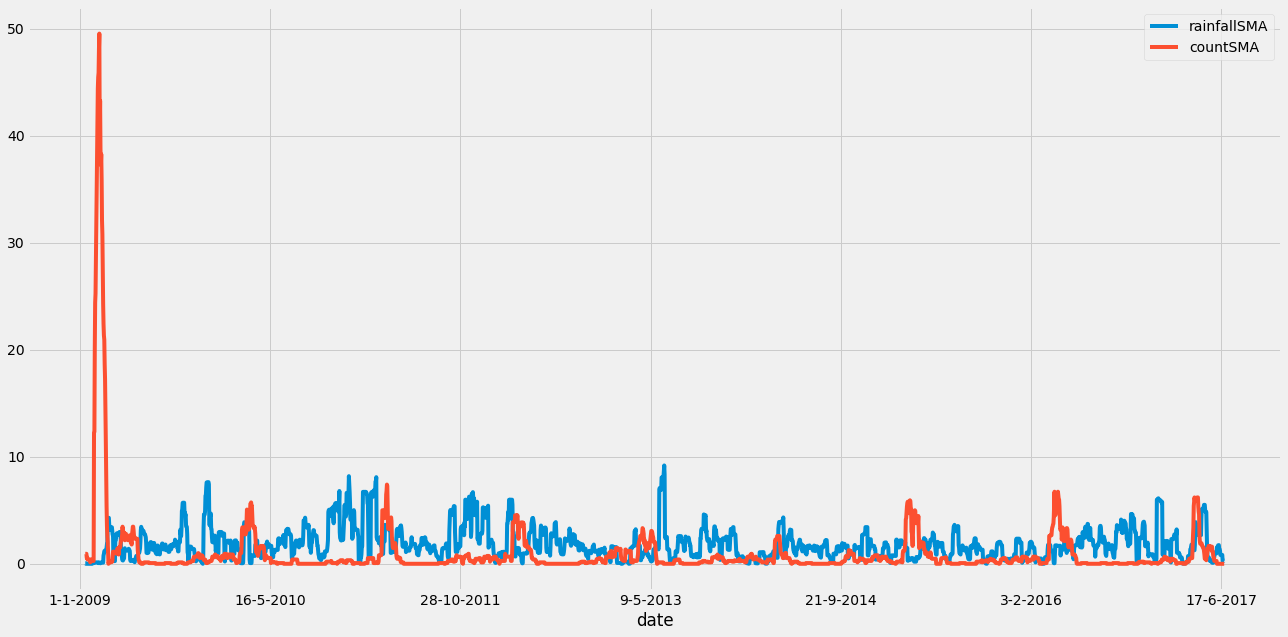

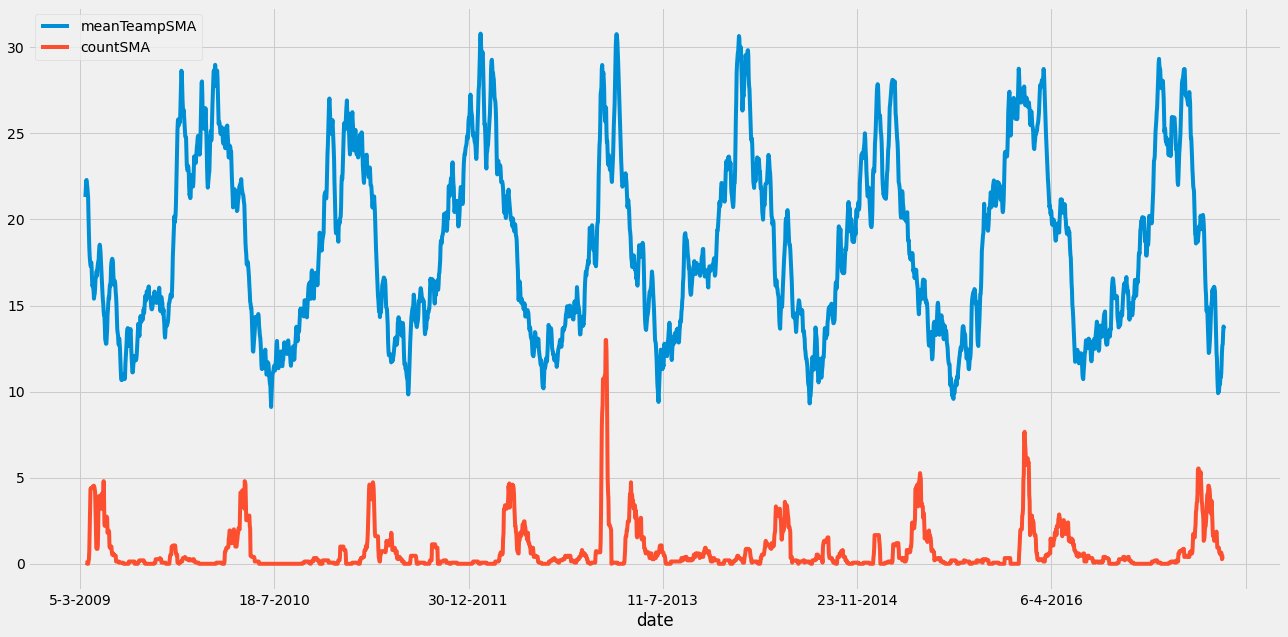

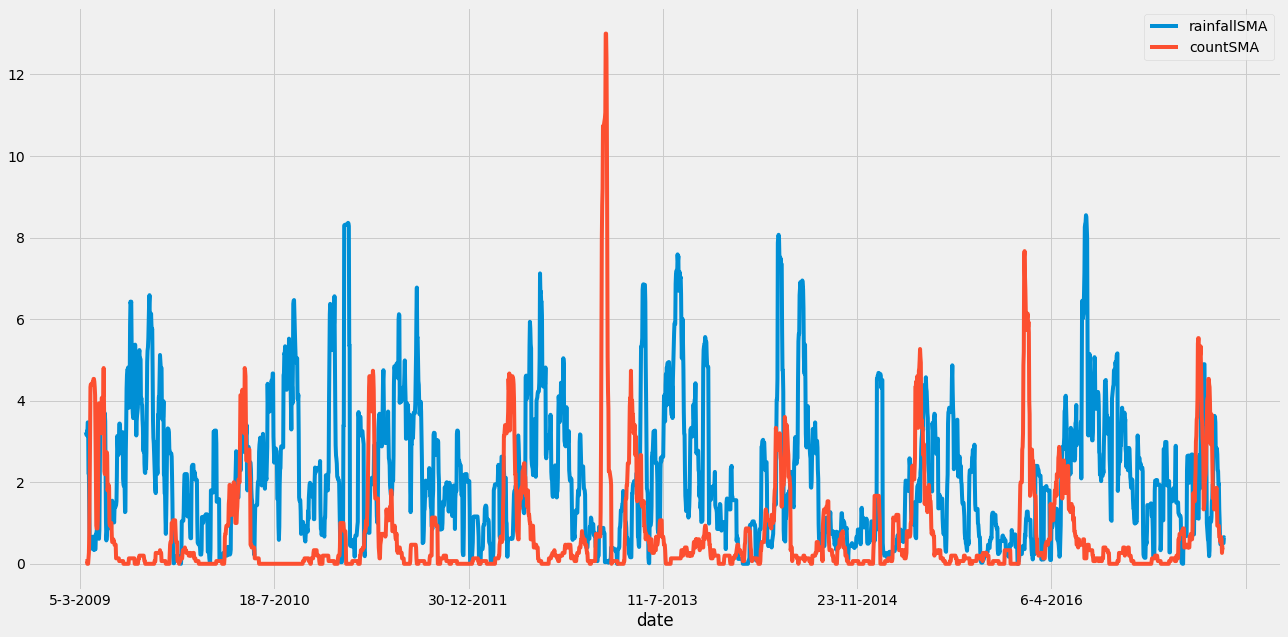

In [18]:
for city in citiesData:
    window = 15
    mediaMovelDB = city[1].copy()
    mediaMovelDB = mediaMovelDB.reset_index()
    for i in range(window - 1, mediaMovelDB.shape[0]):
        mediaMovelDB.loc[mediaMovelDB.index[i], 'MaxTempSMA'] = 0
        mediaMovelDB.loc[mediaMovelDB.index[i], 'MimTempSMA'] = 0
        mediaMovelDB.loc[mediaMovelDB.index[i], 'rainfallSMA'] = 0
        mediaMovelDB.loc[mediaMovelDB.index[i], 'countSMA'] = 0
        for j in range(0, window):
            mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
                'MaxTempSMA')] += float(mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('maxtemp')])
        for j in range(0, window):
            mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
                'MimTempSMA')] += float(mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('mimtemp')])
        for j in range(0, window):
            mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
                'countSMA')] += mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('count')]
        for j in range(0, window):
            mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
                'rainfallSMA')] += float(mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('rainfall')])

    mediaMovelDB['MaxTempSMA'] = mediaMovelDB['MaxTempSMA'] / window
    mediaMovelDB['MimTempSMA'] = mediaMovelDB['MimTempSMA'] / window
    mediaMovelDB['rainfallSMA'] = mediaMovelDB['rainfallSMA'] / window
    mediaMovelDB['countSMA'] = mediaMovelDB['countSMA'] / window
    mediaMovelDB['meanTeampSMA'] = mediaMovelDB['MimTempSMA'] + \
        mediaMovelDB['MaxTempSMA'] / 2

    mediaMovelDB.plot(figsize=(
        20, 10), x='date', y=['meanTeampSMA', 'countSMA']).figure.savefig(
        '../Aditional Resources/Final Graphs/Mean Temp vs Fires/meanTempXCount{}.png'.format(city[0]))
        
    mediaMovelDB.plot(figsize=(
        20, 10), x='date', y=['rainfallSMA', 'countSMA']).figure.savefig(
        '../Aditional Resources/Final Graphs/Rainfall vs Fires/rainfallXCount{}.png'.format(city[0]))


In [11]:
cur = conn.cursor()
cur.execute("select d.month, d.year, wc.temperaturechange from date d join weatherchange wc on d.id = wc.dateid where period = 'm';")
weatherChange = cur.fetchall()
cur.close()
cur = conn.cursor()
cur.execute("select d.month, d.year, count(f.*) from date d left join fires f on d.id = f.dateid group by d.month, d.year order by d.year, d.month asc;")
firesMonth = cur.fetchall()
cur.close()

index = []
change = []
for i in weatherChange:
  index.append(str(i[0]) + '-' + str(i[1]))
  change.append(i[2])

df1 = pd.DataFrame(
    data={'index': index, 'change': change})


index = []
fires = []
for i in firesMonth:
  index.append(str(i[0]) + '-' + str(i[1]))
  fires.append(i[2])

df2 = pd.DataFrame(
    data={'index': index, 'fires': fires})

weatherChangeFiresDB = df1.merge(df2)

weatherChangeFiresDB = weatherChangeFiresDB.set_index('index').astype(float)

weatherChangeFiresDB


change   fires
index                 
1-2008     1.3   469.0
2-2008    -0.4   356.0
3-2008     0.6  1234.0
4-2008    -0.3  4832.0
5-2008     0.7  2283.0
...        ...     ...
2-2017     0.7  1246.0
3-2017     1.7  2619.0
4-2017     0.2  7099.0
5-2017     1.0  5277.0
6-2017     0.5  1640.0

[114 rows x 2 columns]

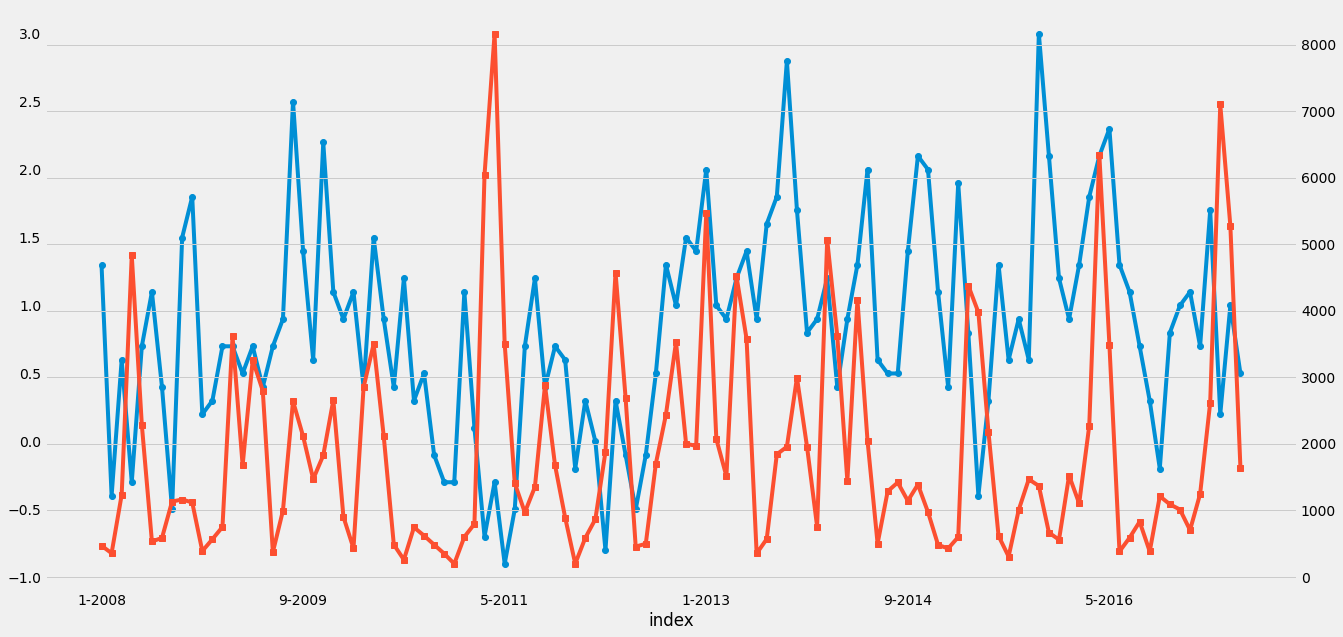

In [15]:
weatherChangeFiresDB['change'].plot(style='o-')
weatherChangeFiresDB['fires'].plot(secondary_y=True, figsize=(20, 10), style='s-').figure.savefig(
    '../Aditional Resources/Final Graphs/TempChange vs Fires/tempChangexFiresM.png')


<AxesSubplot:xlabel='index'>

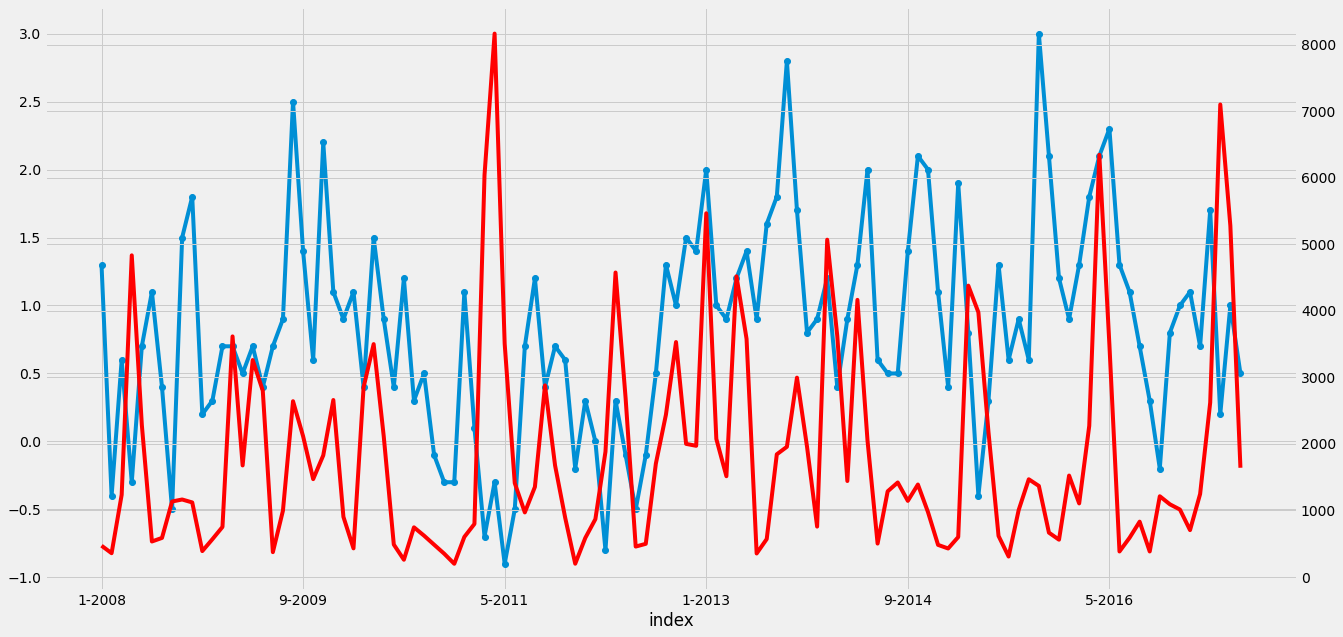

In [14]:
weatherChangeFiresDB['fires'].plot(
    secondary_y=True, figsize=(20, 10), color='r', markersize=1)
weatherChangeFiresDB['change'].plot(style='o-')



In [2]:
plt.figure()
cur = conn.cursor()
cur.execute("select d.year, wc.temperaturechange from date d join weatherchange wc on d.id = wc.dateid where period = 'y';")
weatherChange = cur.fetchall()
cur.close()
cur = conn.cursor()
cur.execute("select d.year, count(f.*) from date d left join fires f on d.id = f.dateid group by d.year order by d.year asc;")
firesMonth = cur.fetchall()
cur.close()

index = []
change = []
for i in weatherChange:
  index.append(str(i[0]))
  change.append(i[1])

df1 = pd.DataFrame(
    data={'index': index, 'change': change})


index = []
fires = []
for i in firesMonth:
  index.append(str(i[0]))
  fires.append(i[1])

df2 = pd.DataFrame(
    data={'index': index, 'fires': fires})

weatherChangeFiresDB = df1.merge(df2)

weatherChangeFiresDB = weatherChangeFiresDB.set_index('index').astype(float)

weatherChangeFiresDB


change    fires
index                 
2008      0.6  14661.0
2009      1.0  24171.0
2010      0.6  12932.0
2011      0.2  28478.0
2012      0.3  23185.0
2013      1.4  27566.0
2014      1.1  23532.0
2015      1.1  17543.0
2016      1.1  20225.0

<Figure size 432x288 with 0 Axes>

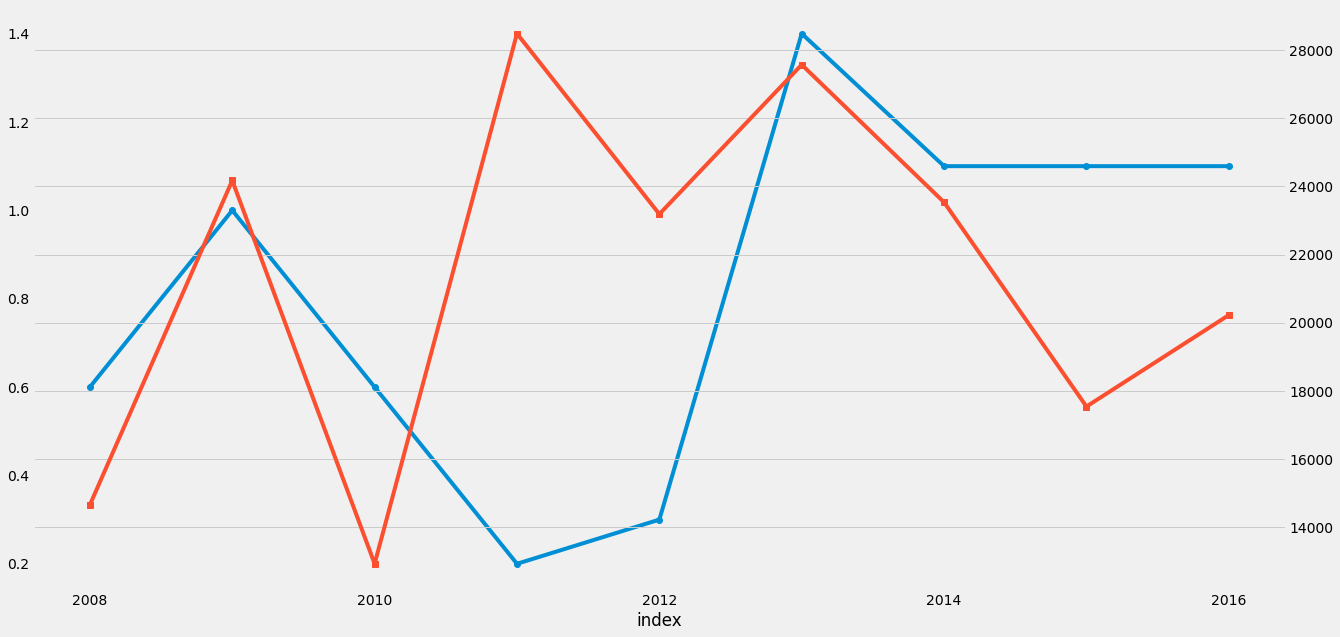

In [10]:
weatherChangeFiresDB['change'].plot(style='o-')
weatherChangeFiresDB['fires'].plot(secondary_y=True, figsize=(20, 10), style='s-').figure.savefig(
    '../Aditional Resources/Final Graphs/TempChange vs Fires/tempChangexFiresY.png')


<AxesSubplot:>

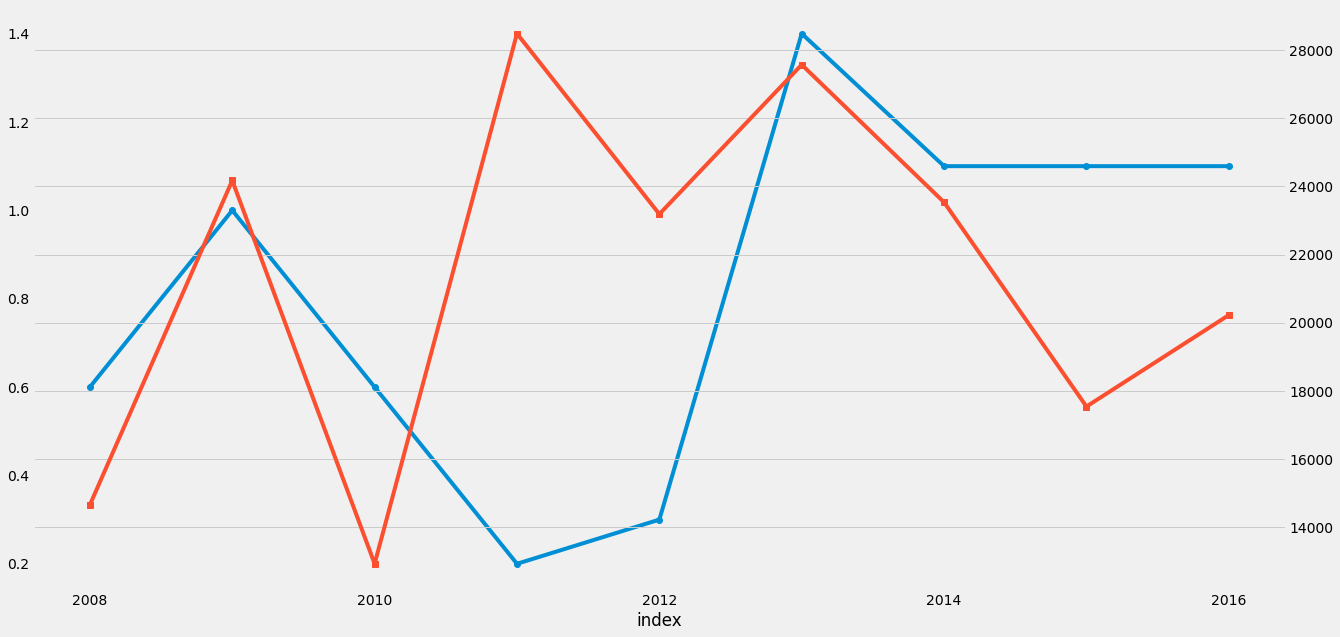

In [3]:
weatherChangeFiresDB['change'].plot(style='o-')
weatherChangeFiresDB['fires'].plot(secondary_y=True, figsize=(20, 10), style='s-')
